This is notebook file is the Solution for Exercise 1 from the [exercise series 3](https://github.com/righetti/optlearningcontrol/tree/master/Spring2020/series3) for the course Optimal and Learning Control (ME-GY 7973), as solved by Tarun Thathvik Paladugu. All the content from the file [Model Predictive Control.ipynb](https://github.com/righetti/optlearningcontrol/blob/master/Spring2020/series3/Exercise%201%20-%20Model%20Predictive%20Control.ipynb) was used as provided by professor [Ludovic Righetti](https://engineering.nyu.edu/faculty/ludovic-righetti).

# Walking using the Linear Inverted Pendulum Model

In this exercise, we will use the linear inverted pendulum model (LIPM) seen in class as a model for bipedal walking and we will derive a model predictive control law that will stabilize walking in face of external disturbances.

The LIPM can be derived from the (complicated) dynamics of any legged robot. It describes the dynamics of the Center of Mass (CoM) of the robot when we assume that the CoM height is constant and that the angular momentum at the CoM is 0.

<img src="lipm.png" alt="missing LIPM figure" width="400"/>

In this case, the motion of the CoM in the horizontal plane (forward and side motions) can be written as a linear dynamical system. In particular, the forward and side motions are decoupled. In the following, we will only consider forward motions and ignore side movement. The forward motion of the CoM, using this model, can be written
$$\begin{align}\dot{x} &= v \\ \dot{v} &= \omega(x - u)\end{align}$$
where $x$ is the CoM position, $v$ its velocity, $\omega = \frac{g}{z}$, $z$ is the CoM height, $g$ the gravity constant and $u$ is the center of pressure (CoP) location on the ground.

We know that, to be physically consistent, the CoP needs to be located inside the support polygon formed by the feet on the ground. In the case where one foot is on the ground, the CoP needs to be inside the foot.

Since the differential equation is linear, we can explicitly solve it for a given $\Delta t$ assuming a constant center of pressure during that time. We then get the following linear discrete system
$$\begin{bmatrix} x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} \cosh(\omega \Delta t) & \omega^{-1} \sinh(\omega \Delta t) \\ \omega \sinh(\omega \Delta t) & \cosh(\omega \Delta t) \end{bmatrix} \begin{bmatrix} x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 1 - \cosh(\omega \Delta t) \\ -\omega \sinh(\omega \Delta t) \end{bmatrix} u_n$$

The idea is to find CoP locations (which will then be realized by an another controller on the real robot) such that we can move the CoM where we want and such that the CoP is always inside the support polygon. We will assume that there is only one leg touching the ground at a time. Assuming that the foot on the ground is located at time $n$ at $f_n$ and that the foot has a length of $l_{foot}$, the CoP constraint reads
$$f_n - \frac{l_{foot}}{2} <u_n<f_n + \frac{l_{foot}}{2}$$
We will also assume that we predefine the foot step locations in advance.

We now have almost all the ingredients necessary to construct an optimal control problem. We just need a cost function. Here, to keep the problem simple, we will assume that during walking, we try to keep the CoM above the foot in contact as much as possible and that we try to keep the CoP at the center of the foot as much as possible. We will also try to keep the velocity of the CoM as small as possible. We therefore have the following optimal control problem
$$\min_{u_n} \sum_{n=0}^{N-1} \left( \begin{matrix} x_n - f_n \\ v_n \end{matrix} \right) ^T Q \left(\begin{matrix} x_n - f_n \\ v_n \end{matrix}\right) + (u_n - f_n)^T R (u_n - f_n) + \left( \begin{matrix} x_N - f_N \\ v_N \end{matrix}\right)^T Q_N \left(\begin{matrix} x_N - f_N \\ v_N \end{matrix}\right)$$
subject to
$$\begin{bmatrix} x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} \cosh(\omega \Delta t) & \omega^{-1} \sinh(\omega \Delta t) \\ \omega \sinh(\omega \Delta t) & \cosh(\omega \Delta t) \end{bmatrix} \begin{bmatrix} x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 1 - \cosh(\omega \Delta t) \\ -\omega \sinh(\omega \Delta t) \end{bmatrix} u_n$$
and
$$f_n - \frac{l_{foot}}{2} <u_n<f_n + \frac{l_{foot}}{2}$$

In [2]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

import cvxopt 

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

## Solving a constrained linear optimal control problem

We provide the function below to solve LQ optimal control problems with constraints as we have seen in class. We will use this solver to construct a model predictive controller for walking. The function solves problems of the form
$$\min_{u_n} \sum_{n=0}^{N-1} x_n^T Q_n x_n + q_n^T x_n + u_n^T R_n u_n + r_n^T u_n$$
subject to
$$x_{n+1} = A x_n + B u_n,\qquad x_0 = x(0)$$
and
$$G_n \begin{bmatrix}x_n \\ u_n \end{bmatrix} \leq h_n$$
where the dynamics is independent of $n$ and the costs and bounds can change at every time step.

In [3]:
def solve_mpc_collocation(A,B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0):
    """
    Here we want to do MPC with a collocation approach
    we assume that A and B are constant but Q, q, R, r and the bounds are given as list of vectors/matrices
    one per time step
    
    it returns a state trajectory and a control trajectory
    """
    # the number of states we will need to optimize for
    num_states = x0.size*horizon_length
    u_size = B.shape[1]
    # the number of control to optimize
    num_control = u_size*horizon_length
    # the total number of variables we need to optimize
    num_vars = num_states + num_control

    # the total Hessian of the problem (the quadratic part) [x u]^T Qtot [x u]
    Qtilde = np.zeros([num_vars, num_vars])
    # the total linear part
    qtilde = np.zeros([num_vars, 1])
    
    Atilde = np.zeros([num_states, num_vars])
    btilde = np.zeros([num_states])
    # we impose the initial condition x0
    btilde[0:x0.size] = -A.dot(x0)
    
    G_tilde = None
    h_tilde = None


    for i in range(horizon_length):
        # we put Q and R in the right places on the diagonal
        Qtilde[x0.size*i:x0.size*(i+1), x0.size*i:x0.size*(i+1)] = Q[i]
        Qtilde[num_states+u_size*i:num_states+u_size*(i+1), num_states+u_size*i:num_states+u_size*(i+1)] = R[i]
       
        # same for q and r
        qtilde[i*x0.size:(i+1)*x0.size] = q[i]
        qtilde[num_states+i*u_size:num_states+(i+1)*u_size] = r[i]
    
        # we construct the equality constraint for the dynamics
        Atilde[x0.size*i:x0.size*(i+1),num_states+u_size*i:num_states+u_size*(i+1)] = B
        if i>0:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i-1):x0.size*(i+1)] = np.hstack((A, -np.eye(x0.size)))
        else:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i):x0.size*(i+1)] = -np.eye(x0.size)
        
        # now we construct the inequalities Gtilde [x u] <= htild
        G_tmp = np.zeros([G_bounds[i].shape[0], num_vars])
        G_tmp[:, x0.size*i:x0.size*(i+1)] = G_bounds[i][:,:x0.size]
        G_tmp[:, num_states+u_size*i:num_states+u_size*(i+1)] = G_bounds[i][:,x0.size:]
        if G_tilde is None:
            G_tilde = G_tmp
        else:
            G_tilde = np.vstack((G_tilde, G_tmp))

        if h_tilde is None:
            h_tilde = h_bounds[i]
        else:
            h_tilde = np.vstack((h_tilde, h_bounds[i]))
        
            
    # we transform our data into cvxopt complicant data
    Qtot = cvxopt.matrix(Qtilde)
    p = cvxopt.matrix(qtilde)
    
    G = cvxopt.matrix(G_tilde)
    h = cvxopt.matrix(h_tilde.flatten())
    
    Atilde = cvxopt.matrix(Atilde)
    btilde = cvxopt.matrix(btilde)
    
    #now we call cvxopt to solve the quadratic program constructed above
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(Qtot,p,G,h,Atilde, btilde)
    x = np.array(sol['x'])
    u = x[num_states:]
    x = x[0:num_states]

    return  np.vstack((x0, x.reshape([horizon_length, x0.size]))).T, u.T

## Simulation of the LIPM

In [4]:
class LIPM:
    """
    This class implements a linear inverted pendulum model - we will use it to simulate the walking robot
    """
    
    def __init__(self):
        """
        constructor of the class
        """        
        #gravity constant
        self.g=9.81
        
        #CoM height
        self.z_com = 1.0

        #integration step (100ms)
        self.dt = 0.1
        
        #
        self.omega = np.sqrt(self.g / self.z_com)
        
        #the transition matrices
        self.A = np.array([[np.cosh(self.dt*self.omega), 1./self.omega * np.sinh(self.dt*self.omega)],
                          [self.omega * np.sinh(self.dt*self.omega), np.cosh(self.dt*self.omega)]])
        self.B = np.array([[1 - np.cosh(self.dt*self.omega)],[-self.omega * np.sinh(self.dt*self.omega)]])
        
        # half of the size of the foot (i.e. the foot is 30cm long)
        self.foot_size = 0.15        
                        
    def next_state(self,x,u):
        """
        Inputs:
        x: state of the system as a numpy array (x,v)
        u: cop position as a scalar
        
        Output:
        the new state as a numpy array
        """
        
        return self.A.dot(x) + self.B.dot(u)
        
    
    def simulate(self, x0, controller, horizon_length, foot_steps, noise=True):
        """
        This function simulates the LIPM for horizon_length steps from initial state x0
        
        Inputs:
        x0: the initial conditions as a numpy array (x,v)
        controller: a function that takes a state x as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        foot_steps: an array containing foot step locations for every time step (this is used to ensure u is constrained to the support polygon)
        
        Output:
        x[2xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = np.clip(controller(x[:,i],i), foot_steps[i]-self.foot_size, foot_steps[i]+self.foot_size)
            x[:,i+1] = self.next_state(x[:,i], u[:,i])
            if i>0 and noise:
                disturbance = np.random.normal(0., 0.01)
                x[1,i+1] += disturbance
        return x, u

## Animation and plotting utility

In [5]:
def animate_walker(plotx, plotu, foot_pose):
    """
    This function makes an animation showing the behavior of the LIPM with some graphics showing the CoP, etc.
    takes as input the result of a simulation (with dt=0.1s), the CoP position (plotu) and the foot step locations fn (foot_pose)
    """
    use_dt = 100
    
    feet_colors = ['b','g']
    c_foot_c = 0
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-0.2,9], ylim=[-.2,2.3])
    ax.grid()
    
    list_of_lines = []
    
    #plot the ground
    ax.plot([-0.1,8],  [0,0])
    
    #create the walker
    line, = ax.plot([], [], feet_colors[c_foot_c], lw=2)
    list_of_lines.append(line)
    #for the CoP
    line, = ax.plot([], [], 'or', ms=8)
    list_of_lines.append(line)
    #for the CoM
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the torso
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    #for the head
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the foot
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    com_height = 1.
    torso_height = 1.
    
    def animate(i):
        nonlocal c_foot_c
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        if i>0:
            if foot_pose[i] != foot_pose[i-1]:
                c_foot_c = (c_foot_c + 1)%2
                list_of_lines[0].set_color(feet_colors[c_foot_c])
                                        
        list_of_lines[0].set_data([foot_pose[i], plotx[0,i]], [0, com_height])
        list_of_lines[1].set_data([plotu[0,i], plotu[0,i]], [0, 0])
        list_of_lines[2].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height])
        list_of_lines[3].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height+torso_height])
        list_of_lines[4].set_data([plotx[0,i], plotx[0,i]], [com_height+torso_height, com_height+torso_height])
        list_of_lines[5].set_data([foot_pose[i]-0.15, foot_pose[i]+0.15], [0, 0])
        
        return list_of_lines
    
    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:-1])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [6]:
def plot_results(x_real, u_real, x_plan, u_plan):
    """ this function plots the results of the simulations"""
    
    time = np.linspace(0,horizon_length*walking_model.dt, len(x_real[0,:]))
    plt.figure(figsize=[8,5])
    # plt.subplot(3,1,1)
    plt.plot(time, x_real[0,:], linewidth=6, label='Simulated CoM')
    plt.plot(time, x_plan[0,:], '--', linewidth=6, label='Planned CoM')
    plt.ylim([-1,10])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM position')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[1,:], linewidth=6, label='Simulated CoM Vel')
    plt.plot(time, x_plan[1,:], '--', linewidth=6, label='Planned CoM Vel')
    plt.ylim([-1,2])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM velocity')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time[:-1], u_plan[0,:] - foot_position, linewidth=6, label='Planned CoP in foot')
    plt.plot(time[:-1], u_real[0,:] - foot_position, '--', linewidth=6, label='Simulated CoP in foot')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) + walking_model.foot_size, 'k--', label='upper foot limit')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) - walking_model.foot_size, 'k--', label='lower foot limit')
    plt.xlabel('Time [s]')
    plt.ylabel('CoP position and limits')
    plt.legend()
    
    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[0,:], linewidth=6, label='CoM')
    plt.plot(time[:-1], u_real[0,:], linewidth=6, label='CoP')
    plt.plot(time[:-1], foot_position, 'k', label='foot position')
    plt.plot(time[:-1], foot_position + walking_model.foot_size, 'k--', label='foot boundary')
    plt.plot(time[:-1], foot_position - walking_model.foot_size, 'k--', label='foot boundary')
    plt.xlabel('Time [s]')
    plt.ylabel('Complete simulated pattern')
    plt.legend()

# Planning a walking trajectory 
We can plan a walking trajectory by solving the OC problem above as follows

<IPython.core.display.Javascript object>


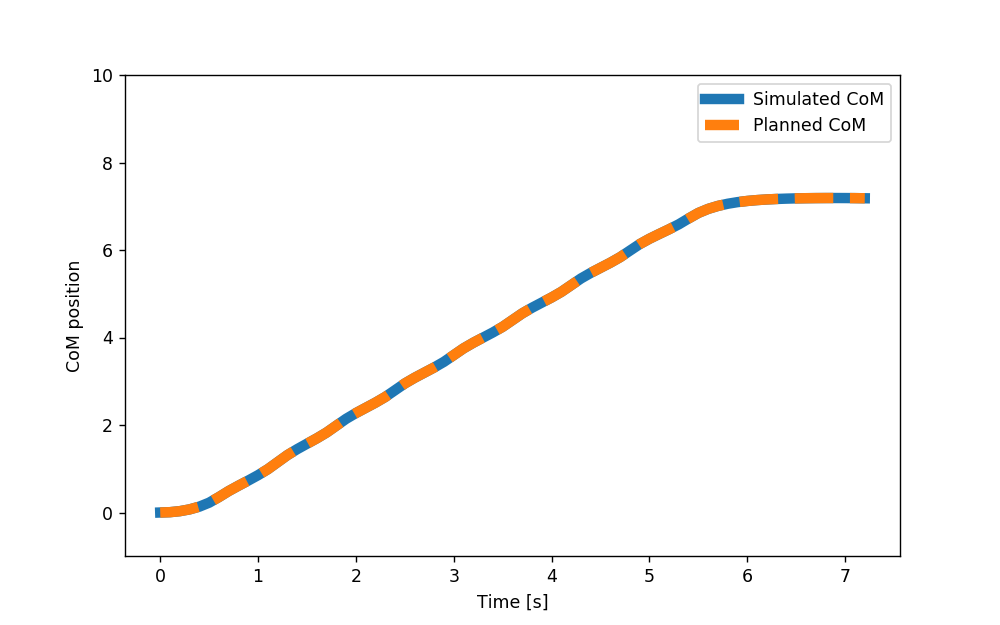

<IPython.core.display.Javascript object>


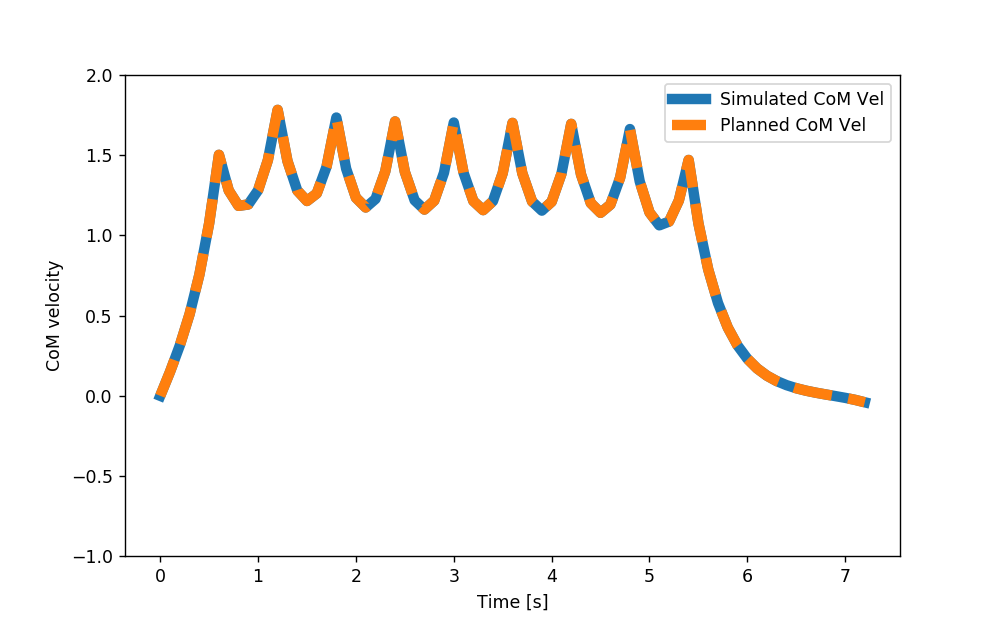

<IPython.core.display.Javascript object>


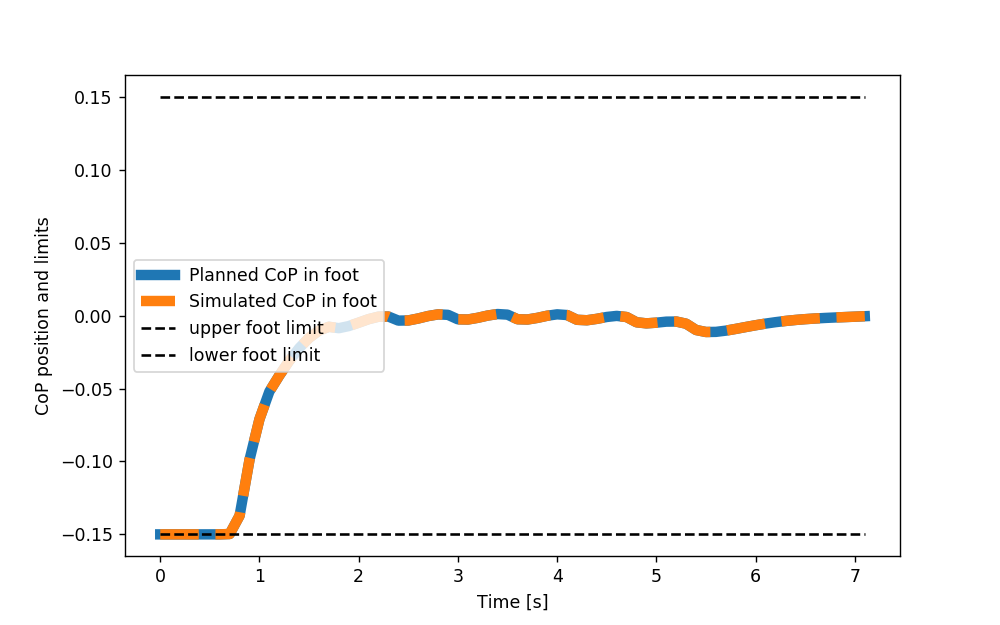

<IPython.core.display.Javascript object>


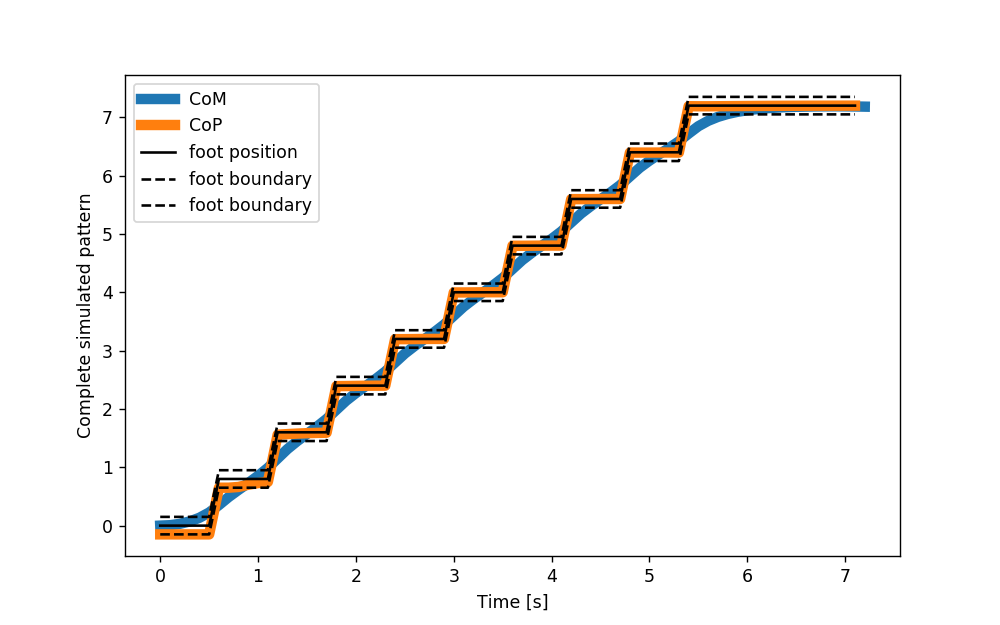

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABXMW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAxxZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjphAZbmOcdwu2wwaf+QclE2IUVk7ICD
zJkRF6bPgKTPzWnSr9U8xGHk5+fHmDav88T7bN0ep4YwmFW6pWH+mGrcke8xJSTw5f1OUdEoN0Ub
K4/HFPGdmYr3lgMgW+4SsXz4XG3yc3Gad9bpIovCBtK5IJ4cxa6fh80h0FXv48SJ4gK8jcdWOY/S
xY/gxx/TjMLEPuFI64ylSY5Vy9C+mX8n3yzoyBgjuPmKcCLOVei2bbQU5Xj34unOt2zx1g6cI8fe
iSu2jNC1655rRG9mlMSxZbo2Xv5s5+eflWtVujVr4ny8yilCKi7HElx9c31CpvDqAJv7TNohh9Z2
Pnluqm52U3QQ514fjfsvmRRrtc3K2FleF0vC5oQ5M4EOCa8X0esLuH33M8KR5yTtlpP/XsLFS5vl
6ZlPVZ4i4jGDqFMc4SkfEczP+826nznvvnV1GWLufgsm32Q1eD2HLjknWbk4Uc7ZkqBVXyXnHgOT
o1cPyLf5VB3OV0Z7sk/4HwduIceOExjzCmWnUzSpBh9k3zNDJt3NN6gshicCTuzU/V+KqNyv/c9I
4OHcgWLcphxs2uXSUD3p1waL2GA3JeWGTdofKjad12/fWkXm3LbHD23pJTjBCyOBFXpS1Xpz7xBn
8dlbUNZ5CqFksZDQBfHa9FDh1HAVPQkYi8noCtBSBl+l0f7BqqYEtYp5bvR4yW7MZgZOAlS203my
IKtd+oO/gqDnsZj6tphbio+WvlF72Owu4fTKvn4EH/8oN6Gs7RP+Dz+b1vnEOwNm2v5CwUaXax0D
4S9TOGhbilCq7mGrHw8KfawpADpBj35cVXlpmRhJxBNhac6UGlLTE5zPWHGq9+pZMPszMPgVeBIf
dftLgOgP4qUETDlJtGhiKX0MWjLjtODM7a4hGQudj8K8n+d+19q+Lgm+lySOlqIDvr2HwMFkxwze
b1VGag8x/OGPNZCgEYN6OUnSUohZFyDIlYnpBgVoF0MkrCcv+MMwRI/z/PrLt+Vv9lvxFIoRIogT
mpbIeNDjTG+AjLf3/uG/GoEukqsDcVPpSe5F2rNuyshaHn+O3kxGaxSnLU8aOc57GHted++3LCFF
KnXGHwm2oJABy23xNaA/UUvJmJTZLMfqAaaapE6LRZmBUsluAZzb+SSZ/Yu4ryXiJycMxRyM75OJ
t1ZMGJkALa2DSANVlfcul6x8dKk+uVTcM3/nd5Tw3nOryJ6kaT1N1HhP+uy5gG8Xput26yUgJ/yw
3djOq5cWzKr1M1eVk61s1N9MX9e76AwUMw/6XkL0kFQClVIa+jd9gescT6KxuQYOXUlKQLrE4Ose
6hSaD2YFMMeoYCqcPdsA8Wc4/OwmFxXXuLjLez09oXpKI0BMucS58nug8OViccm/uTn8sozbGM/Q
Lgv1/BWNfUH2ljn3NFpZNdJKVYCPXH9utxyNTECKD+JYIk5VYeNPwSkpda3YEQysbzOxK3SY/rcZ
vDF1FBCaReYpSMBRiNo+qd2L8DgErIB7tRRsX/d27XmXAuMrPLN2PwJJvdTnnZ3m36zKrJgADuUL
qAtcR/D0a6lffYNrjM9Ysq/ZYZw+AdpyDM0ZfVNUYhYZ3Hr9TJNPEfUpIK7UowJ063w1LeILtXA1
A6U1phzmMLv8lmiNdiv2TCr4fTgJS6PlCrHkJS6g+uCOC/YP+ZWKplwsJ2Fp134RHs0QgpbN3nAj
066BU565iOOrbYRIq4b61oZivvx0cB1YR4Ih4IYDoNwlHe3z3qUsqcFw+opZu55MNVNLXGCQXKoa
LXnAQov/t+mNUVlQ2+N3K8duCYmDs6OgHhJODS18lAN3cKb5dFoZU5I+tXtUZoeKFb8aIKAbZZPH
dbwKU32ubZnXeVBSavGGB31pywI9opNYzxwQ5zFeANtt+KRy/C/fxOK/9hIiT3tAAAA4C4eyKLyl
jHgDBQ2KUbJMNnSNkHcvBy6icowrjcqpXQGSlBdYrAkbYB+3TQcHFIT8mANqBIkT3HnJo6MMnYkC
cnn37thC5bpvHO+3B6xAuEukO94BBJlRPH/py3H76MqObE/2/tVZusUIIuIabQtv9BhpM0yDWtab
fsJQ8FCSLmbvtYvH+geAuACoA7IsAU7Ax0mqhev4Pn3BAMugPLDw+tTjSTPdBlzqx/WWt/8tn2I0
N0n0cviP4HBtI6LhJYP1ggcp2hZ2WmEWI+TMl/DJ1JN91lhI9FGoMj4rvCgwdB2XUMZNdsUOHsf7
OQgsrN0rEy3EzBbKb5gY/onFWuNgH20lQMa3pZttUnu89jwm0TW6/YrvjOzrJ+rb0wsUFiNZLOBQ
1Nl4B8j1q3vDyoGce6ZZq8a/CsQ8pRQiDzPGrHjRTyKwd5JKTqv2XSejXiHI3ObDcoYvQ7RDHEoH
chX68USxJDzCSFnc7N4ukZD1xdy/sX2EUUNvjNyg9UfsxX8IH1EfWbPYWeBkicvf3NRLieudp9N/
YdJPzSyqecd7Enl3CVCwt1PRUQa12xTwgvxUntF8HheS5vSmafzcjVp8k2/LVqhNpJjTuJIrqD6f
WiR0yUZClUrX0hansUrY9/n/yrsWAo1/n8ViPADj5K3QVhoW7yspPL2aN0dhPlqpjoBWqkOlefzb
miksPuB++aI4DxPQuyfj2

In [6]:
# first lets create a walking model
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(step_time / walking_model.dt)

# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2)
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))

# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)

# we now define a controller that will simply use the computed u as a control
feedforward_controller = lambda x,i: u_plan[0,i]

# we simulate the LIPM using the feedforward controller (no noise)
x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length, foot_position, noise=False)

# we plot the resulting motion vs. the motion that was planned and the associated CoP
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

We are able to compute a plan but when the simulation has noise (e.g. the robot gets pushed or we need to account for errors coming from the simplification of the LIPM vs. the real robot), the plan cannot get the robot to walk. This is shown below.

<IPython.core.display.Javascript object>


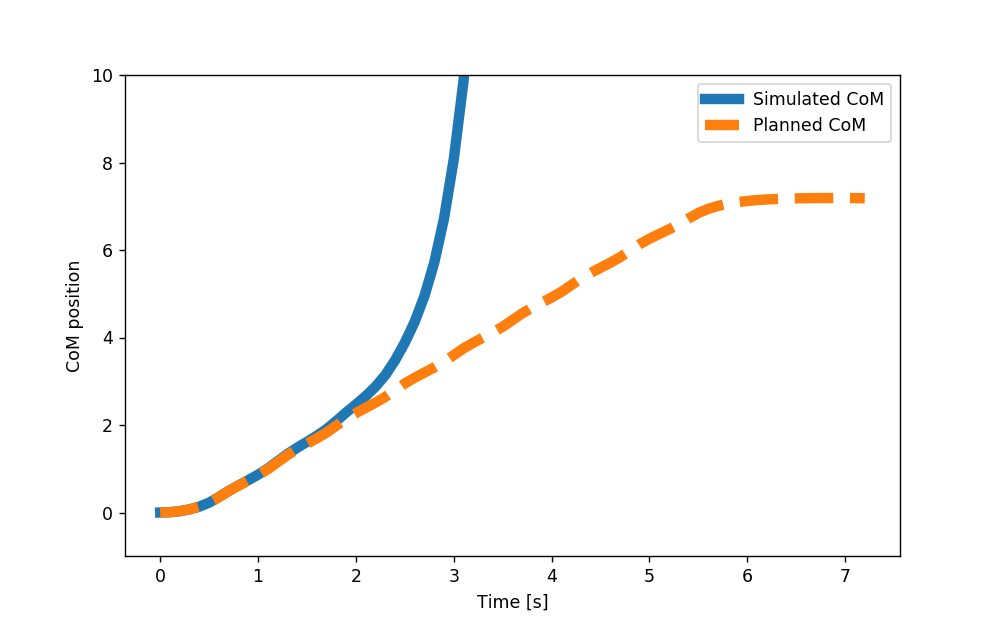

<IPython.core.display.Javascript object>


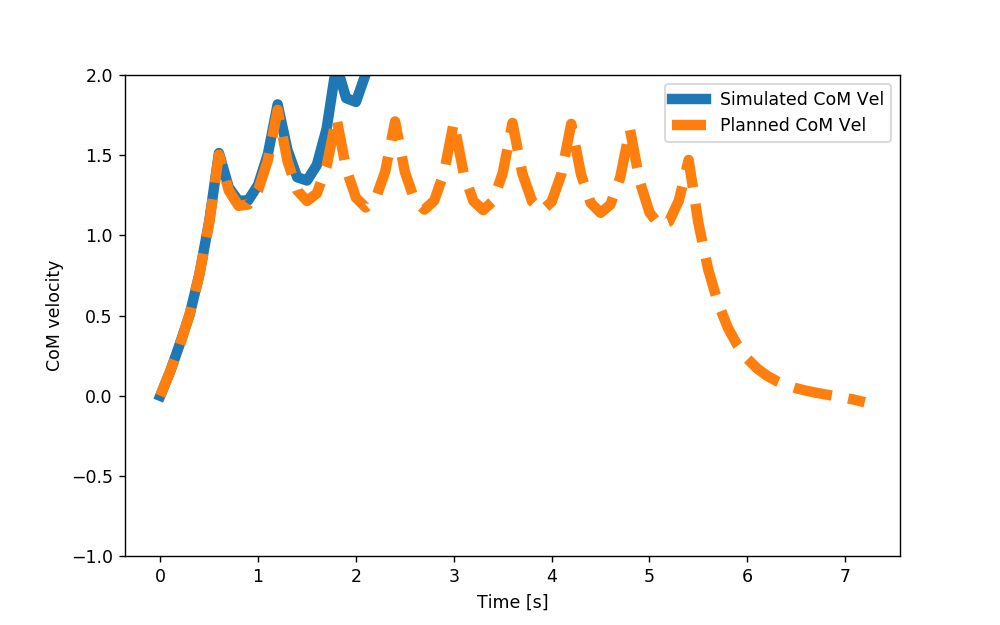

<IPython.core.display.Javascript object>


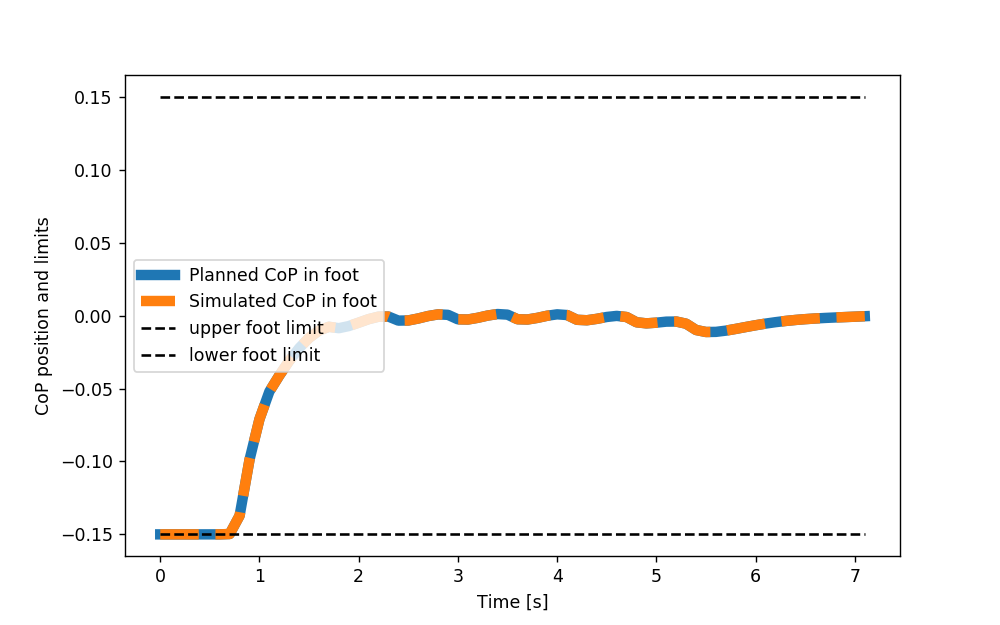

<IPython.core.display.Javascript object>


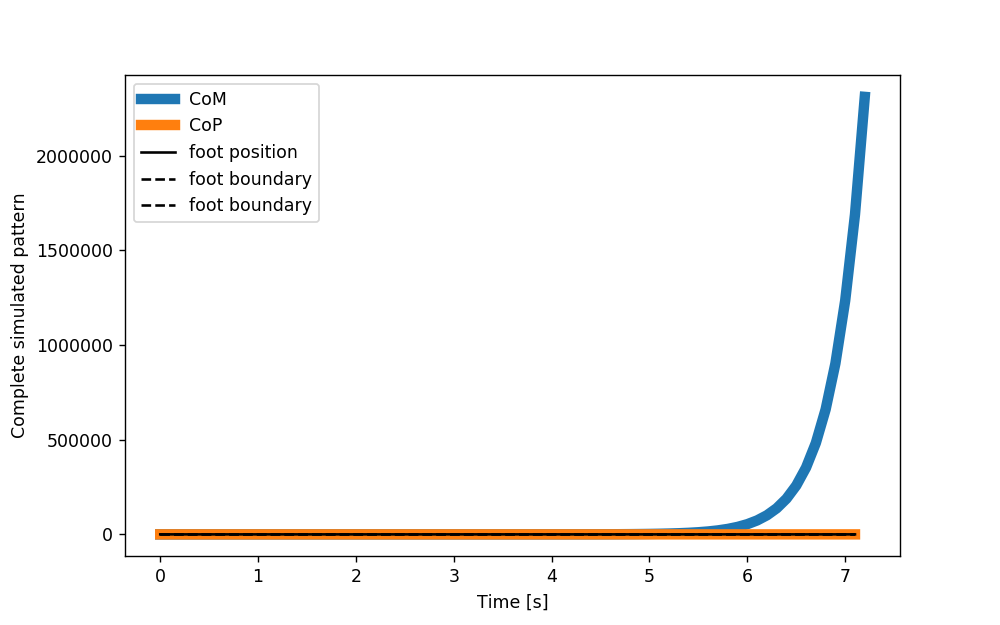

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABeCG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAx/ZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjphAZbmOcdwu2wwaf+QclE2IUVk7ICD
zJkRF6bTnhVTeGhZaVM5t1tp76QeYwtZ9a21U6INDaifb7bmglsL3t7dC6pXiwg5f1OUZflnCls2
b8cUzgh6xu8sBVBoL8lMF67LzvgcqYSGEl2dE3iD8ie2JlOR34cI87FG4rqSzVaWBMoHv+oOk83C
aLpf1ZvVfbjxNitXMBd7s2PFnLui/jNqtI5VtcT0RypN2YqGAQK/vAlakoVY697k75hXQ6o/jB3i
oGZ4rFjVjzgwG9k84SrvmMB7hmg5s925KiAa4PKpVwy6amaCvFdQ9EzWeNkk0LeaWgFZ1Lj0gy6m
+jPOIpv7V/KYBs8KQlhivC6Xhc7wrriVAMbhTK+gLaynF6+ePM/po8BX2jo+QLY/pObvcHZNj15U
i45dCfhdSDow5uP8dTGqiC+7FwSukWDPRrbGsxBXjpCoKB9Js7fRABrCnyTuG+l2fyRDx8+6pFin
96ZSv36W8czA8jwe622P5qYr0rlr05IFBhv64+yhfSfYmnyJcLtlGfGZUenGLhRjkEhRfzO1xI50
QmOsi50y6ug4ZIyHYHVGGnP0uhG+9CwKMg2ebrVvyOB4r3uVEFavHPyKqOLYyFgEdvoCUhMO7Ixq
Gs8pMZksZFICndHRQ5N2XA3AacHGftTbuGTLgdfHhHgqpgS1inlu9HjTvlYVssITbxzm837BV8lD
C+DpiUJjL1ALGG5SidHOTHyE4uTDKMYPs/aD/02/JJ0BcKlroMJ2nLFle3bTyo9bwXQNxu/BxUQ5
omGvVeY00getRhT7WFIAdIMe/Liq7wdlCs12XlM6XKRE5Mv7ToOHQlgUP9V/QVWIgQoKmoceVUuA
6A/inn85WVEr4elc3iTivgqnMoJcuuE/wKoG1oBT7w1F+5uFcb5PJI6T72tO21DaACdJLVet6P5E
o+b4WXRQqUKzWVc3D5GGbTLnugxlKgWJ6QhJmZyOLcRjR/ij/L7bRfTvwlhnh6WcZG3OChKmxBS+
FHkSi8qW3PADVAtJB1qNR48RkN/drBx0uIH7N1tgJFD55xH/z/gTI1qR3EgbbPNVbibbaewIJo19
vsNOuN1CIVrq+ccXjvl3ALmwxPy+CIT+rsYLeieLsNR+oynmWQBnhMLdOfsfLmfJ7tugWlM2rU5R
QDa6o+IChxgQI3tRu92iV9y6XrHx0qT65VNw1ZkzpbeE+i/fT1I1SvOF7Cf9dlzAN4vTdbt16QOE
YI1SbGdVy4tmVicKjnzJ1rZqb6iHRpc0BgoZh+PGUASVvJQsIO2q9Z3QW8WVCkeUy+VuXGJTXTq6
emQWVQ5Uyg9mrBIMIsBVOHu2AeL225QlFEYbRJSPsoD9taF6Sii0TLnEufJ8QVIlYnHJvRz7/aSS
qumM4EGUIfugrGviFmFxz7mi0smuqz2UOVw0pbLnPa7599ts+b/+s3qag+imAEla6WKVqR+KjDBc
j6LtcG9kPo75YszOIAGnq9cOrNINPNwgGp2IpJWe5QB11nlNjS9cJ+ORhPX+h9jzavwuk1/kkmaT
3igKQ0aAAFai05wCRKr3l/1rI+QcFxfMJgh9tbtNBZZFZ+2pheLch2Ua4BCQ/w0m08R9SkgrtSkZ
ii6NdZbxBdq4GoHXStMOcxhd/ks0Rrr+ns2kBKXfLtLEwklNo75wlXz8e56rfT747cCKGJBRhEho
xCCls3ecC75sTKeHrmI46tthEirhvrWhmK+/EBwHVfw8GC3TBU7hbO9CGwkOsaH93R4l6cPajbkW
voFqyI52ZfUPQOFnL7Z2APmOHuWZThdOVZVG7jXyUA3dwpvl0UJlThogE+1Rmh4oVvxogoBtlSu/
+/VwUq8GaHrYXVBy91Js+M7u+APnn6DBJjfIBY9jSf1PrwEV8L95rVIFh6SY4AAAAwAX5kPbT7Ge
vEX0m3hKQxl06xeoRs9Gh3UTlGFcblVK6AyUeNrFYEjcW37poODikJp7gG1AkSJ7jzk0c22/sSBO
Tz792whcpjBqnfbg9YgXCXSHetuHoSmXAKsEROS/IomhRP9v7VWbrFCCLiGQ/VxWdNWpXLn1rW2J
FhISMO0XM3faxeP9K6gEeg047vVlq6/fx1rODQ2WzzSVVIjYeLnMAjiUYRELYnZGVnv+Fk7UhQaW
BHL43zJdbQvPXLRZbISYWbVQDYdPuqsr+gShTWs/fDV1+poL7FX925D0tfW2w84qF3X1Kg+wmgS2
QjpqVI0Y91h2Tr6HNuDzDXcY/i+2cS9Fbtt+IZCXO7chShdlQi/qcsJHXmYoLTSv1zVZonhz3Wek
GVKX6vuawvtnL7qEP2rwktR3YoxVNzxBFF1IP7mokWXZ48/NT6yzY3IliDuxdQkEk1EUJGkemBkW
RCoEIJUQTpZmfBpdm8XSMh7Q1X6ZWtTXYsKtDGNP/H3XQcL65qRa9mSasJK93XsXCQI4MJPXHsKG
XFBO00Un4Pbgo3vEZhD25CIqINa7Yp2vwXJPT2VB4XkubIHd7SaM3U+Sbez7YJrMt3QVehAWF4kZ
3NquNjRe81zaXpphddGcv05mV11x0GA0kjxS7xbzYVnrV387PCyCvZHEVoHhCsYbHzDSZ5xlegtp
4mByddPuLzexRGHYPT26f

In [7]:
# we simulate the LIPM using the feedforward controller when the simulation has noise
x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length, foot_position, noise=True)

plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

## Questions

a) Using the example above and the OC solver, write a model predictive controller that re-computes the optimal control at every instant of time as a function of the current state x. The idea is to solve the original OC problem for a shorter horizon and apply only the first control and repeast at every iteration.

b) What is the shortest time horizon that you can use in the MPC controller while still getting a stable walking in a noisy environment? (the simulation is stochastic so you may want to test your algorithm several times to get an "average" behavior). 

c) Relate this horizon time to the duration of one step. How many steps in advance is it necessary to plan for to get a stable controller?

d) How different is the executed control compared to the originally planned one?

e) What happens if you change the weights in the cost function? What if you increase the terminal cost (e.g. to $10^9$)? Can you decrease or increase the receding horizon length? Describe qualitatively the behavior you observe.

### Part a)
A model predictive controller that re-computes the optimal control at every instant of time as a function of the current state x is implemented in the block below &darr;

The variables x_plan and u_plan are defined only for the plot.

<IPython.core.display.Javascript object>


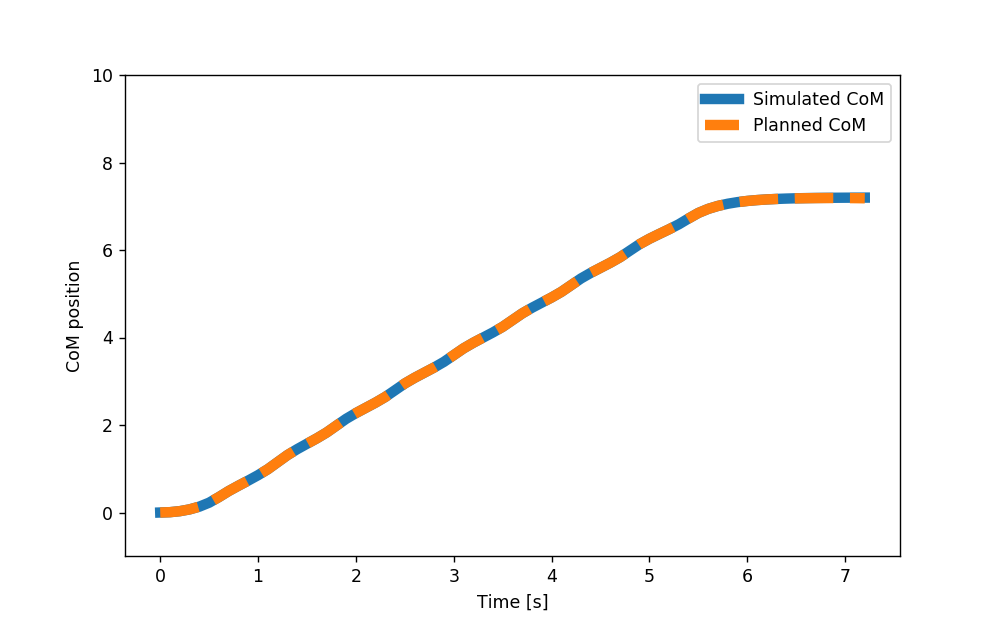

<IPython.core.display.Javascript object>


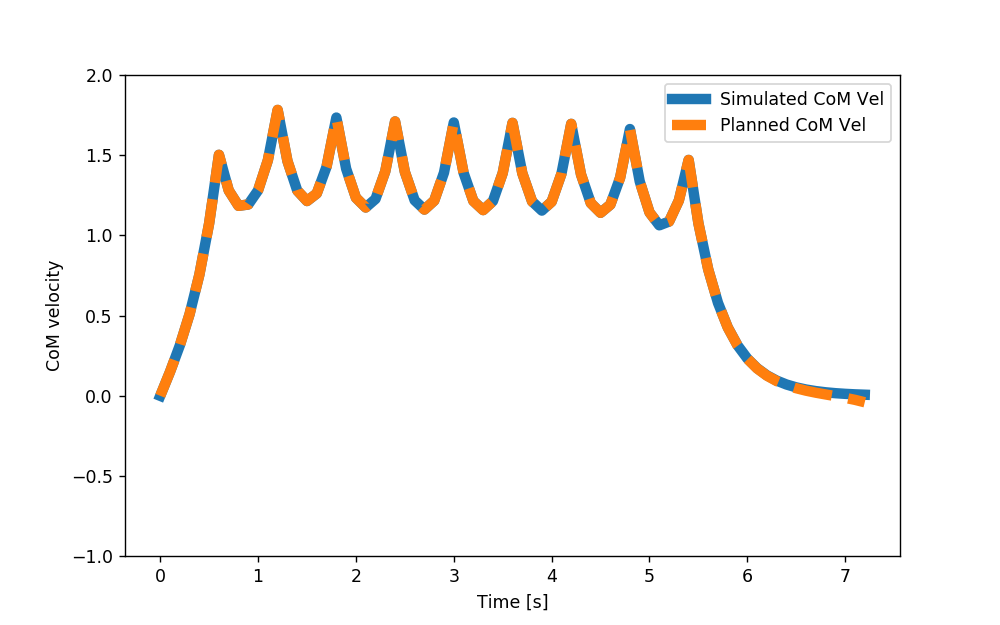

<IPython.core.display.Javascript object>


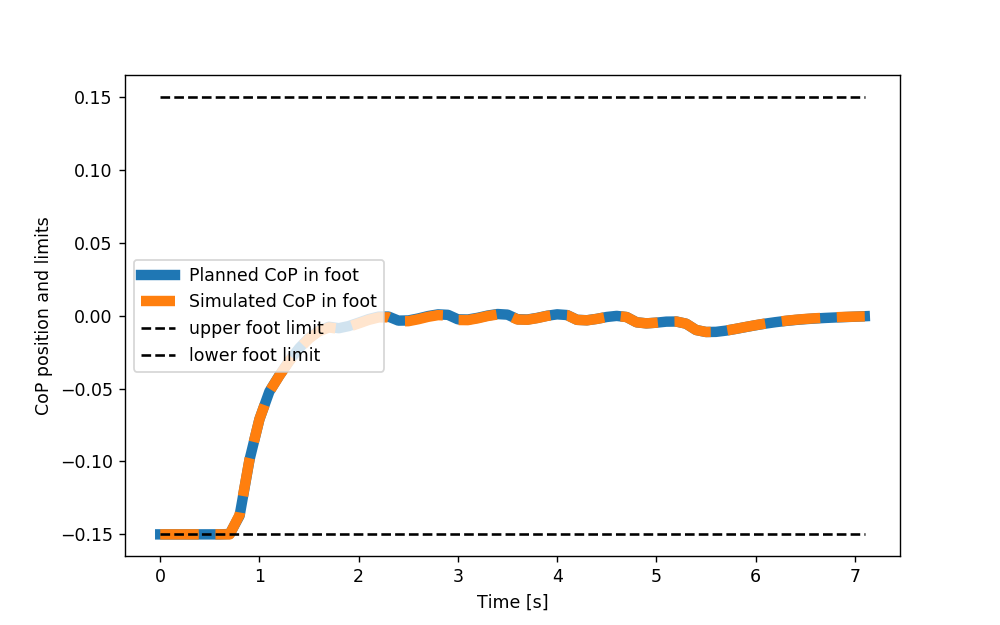

<IPython.core.display.Javascript object>


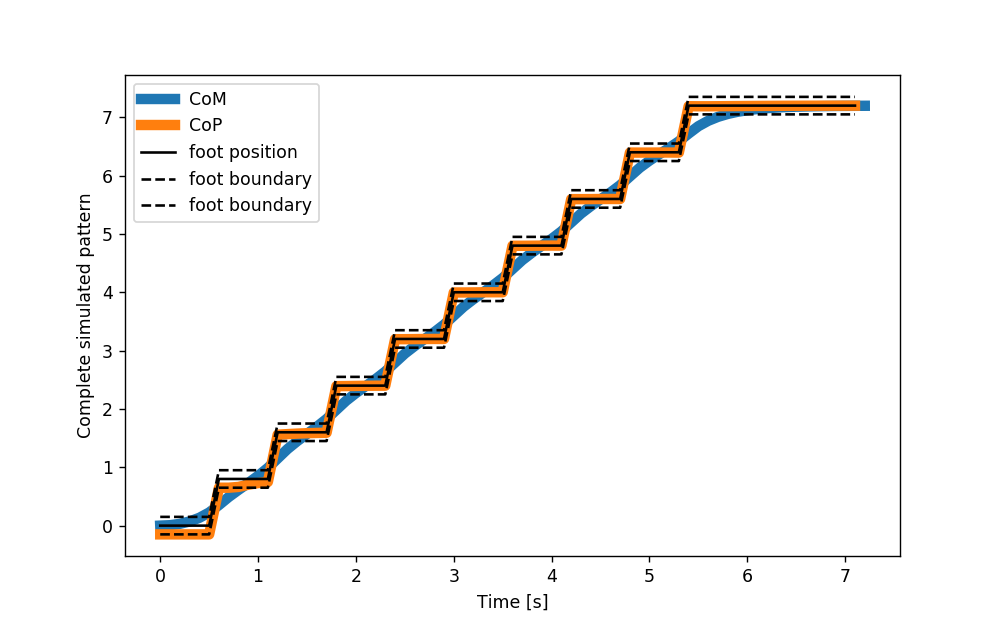

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABXqm1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAxxZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjphAZbmOcdwu2wwaf+QclE2IUVk7ICD
zJkRF6bPgKTPzWnSr9U8xGHk5+fHmDav88T7bN0ep4YwmFW6pWH+mGrcke8xJSTw5f1OUdEoN0Ub
K4/HFPGdmYr3lgMgW+4SsXz4XG3yc3Gad9bpIovCBtK5IJ4cxa6fh80h0FXv48SJ4gK8jcdWOY/S
xY/gxx/TjMLEPuFI64ylSY5Vy9C+mX8n3yzoyBgjuPmKcCLOVei2bbQU5Xj34unOt2zx1g6cI8fe
iSu2jNC1655rRG9mlMSxZbo2Xv5s5+eflWtVujVr4ny8yilCKi7HElx9c31CpvDqAJv7TNohh9Z2
Pnluqm52U3QQ514fjfsvmRRrtc3K2FleF0vC5oQ5M4EOCa8X0esLuH33M8KR5yTtlpP/XsLFS5vl
6ZlPVZ4i4jGDqFMc4SkfEczP+826nznvvnV1GWLufgsm32Q1eD2HLjknWbk4Uc7ZkqBVXyXnHgOT
o1cPyLf5VB3OV0Z7sk/4HwduIceOExjzCmWnUzSpBh9k3zNDJt3NN6gshicCTuzU/V+KqNyv/c9I
4OHcgWLcphxs2uXSUD3p1waL2GA3JeWGTdofKjad12/fWkXm3LbHD23pJTjBCyOBFXpS1Xpz7xBn
8dlbUNZ5CqFksZDQBfHa9FDh1HAVPQkYi8noCtBSBl+l0f7BqqYEtYp5bvR4yW7MZgZOAlS203my
IKtd+oO/gqDnsZj6tphbio+WvlF72Owu4fTKvn4EH/8oN6Gs7RP+Dz+b1vnEOwNm2v5CwUaXax0D
4S9TOGhbilCq7mGrHw8KfawpADpBj35cVXlpmRhJxBNhac6UGlLTE5zPWHGq9+pZMPszMPgVeBIf
dftLgOgP4qUETDlJtGhiKX0MWjLjtODM7a4hGQudj8K8n+d+19q+Lgm+lySOlqIDvr2HwMFkxwze
b1VGag8x/OGPNZCgEYN6OUnSUohZFyDIlYnpBgVoF0MkrCcv+MMwRI/z/PrLt+Vv9lvxFIoRIogT
mpbIeNDjTG+AjLf3/uG/GoEukqsDcVPpSe5F2rNuyshaHn+O3kxGaxSnLU8aOc57GHted++3LCFF
KnXGHwm2oJABy23xNaA/UUvJmJTZLMfqAaaapE6LRZmBUsluAZzb+SSZ/Yu4ryXiJycMxRyM75OJ
t1ZMGJkALa2DSANVlfcul6x8dKk+uVTcM3/nd5Tw3nOryJ6kaT1N1HhP+uy5gG8Xput26yUgJ/yw
3djOq5cWzKr1M1eVk61s1N9MX9e76AwUMw/6XkL0kFQClVIa+jd9gescT6KxuQYOXUlKQLrE4Ose
6hSaD2YFMMeoYCqcPdsA8Wc4/OwmFxXXuLjLez09oXpKI0BMucS58nug8OViccm/uTn8sozbGM/Q
Lgv1/BWNfUH2ljn3NFpZNdJKVYCPXH9utxyNTECKD+JYIk5VYeNPwSkpda3YEQysbzOxK3SY/rcZ
vDF1FBCaReYpSMBRiNo+qd2L8DgErIB7tRRsX/d27XmXAuMrPLN2PwJJvdTnnZ3m36zKrJgADuUL
qAtcR/D0a6lffYNrjM9Ysq/ZYZw+AdpyDM0ZfVNUYhYZ3Hr9TJNPEfUpIK7UowJ063w1LeILtXA1
A6U1phzmMLv8lmiNdiv2TCr4fTgJS6PlCrHkJS6g+uCOC/YP+ZWKplwsJ2Fp134RHs0QgpbN3nAj
066BU565iOOrbYRIq4b61oZivvx0cB1YR4Ih4IYDoNwlHe3z3qUsqcFw+opZu55MNVNLXGCQXKoa
LXnAQov/t+mNUVlQ2+N3K8duCYmDs6OgHhJODS18lAN3cKb5dFoZU5I+tXtUZoeKFb8aIKAbZZPH
dbwKU32ubZnXeVBSavGGB31pywI9opNYzxwQ5zFeANtt+KRy/C/fxOK/9hIiT3tAAAA4C4eyKLyl
jHgDBQ2KUbJMNnSNkHcvBy6icowrjcqpXQGSlBdYrAkbYB+3TQcHFIT8mANqBIkT3HnJo6MMnYkC
cnn37thC5bpvHO+3B6xAuEukO94BBJlRPH/py3H76MqObE/2/tVZusUIIuIabQtv9BhpM0yDWtab
fsJQ8FCSLmbvtYvH+geAuACoA7IsAU7Ax0mqhev4Pn3BAMugPLDw+tTjSTPdBlzqx/WWt/8tn2I0
N0n0cviP4HBtI6LhJYP1ggcp2hZ2WmEWI+TMl/DJ1JN91lhI9FGoMj4rvCgwdB2XUMZNdsUOHsf7
OQgsrN0rEy3EzBbKb5gY/onFWuNgH20lQMa3pZttUnu89jwm0TW6/YrvjOzrJ+rb0wsUFiNZLOBQ
1Nl4B8j1q3vDyoGce6ZZq8a/CsQ8pRQiDzPGrHjRTyKwd5JKTqv2XSejXiHI3ObDcoYvQ7RDHEoH
chX68USxJDzCSFnc7N4ukZD1xdy/sX2EUUNvjNyg9UfsxX8IH1EfWbPYWeBkicvf3NRLieudp9N/
YdJPzSyqecd7Enl3CVCwt1PRUQa12xTwgvxUntF8HheS5vSmafzcjVp8k2/LVqhNpJjTuJIrqD6f
WiR0yUZClUrX0hansUrY9/n/yrsWAo1/n8ViPADj5K3QVhoW7yspPL2aN0dhPlqpjoBWqkOlefzb
miksPuB++aI4DxPQuyfj2

In [8]:
# first lets create a walking model
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(step_time / walking_model.dt)

# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2)
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))

# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)


#Defined the model predictive controller
def model_predictive_controller(x,i):
    
    #horizon length used for the controller 
    horizon_small = 30

    # now we can construct the optimal control problem as follows
    # we will define bounds of the form G_bounds [x u]^T < h_bounds
    G_bounds_new = []
    h_bounds_new = []
    # the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
    Q_new = []
    q_new = []
    R_new = []
    r_new = []
    
    for j in range(horizon_small):
        if i+j >= len(foot_position):
            current_foot_position = foot_position[len(foot_position)-1]
        else:
            current_foot_position = foot_position[ i + j ]
            
        Q_nominal_new = np.eye(2)
        Q_new.append(Q_nominal_new)
        # we want the CoM above the foot and 0 velocity
        q_new.append(Q_nominal_new.dot(np.array([[-current_foot_position],[0.]])))

        R_nominal_new = 100*np.eye(1)
        R_new.append(R_nominal_new)
        # we want the CoP in the center of the foot
        r_new.append(R_nominal_new.dot(np.array([-current_foot_position])))

        # we create bounds for the CoP location
        G_bounds_new.append(np.array([[0,0,1],[0,0,-1]]))
        h_bounds_new.append(np.array([[walking_model.foot_size + current_foot_position],[walking_model.foot_size-current_foot_position]]))

    # now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
    x_new_plan, u_new_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q_new,q_new,R_new,r_new,G_bounds_new,h_bounds_new, horizon_small, x)

    return u_new_plan[0,0]
    
# we simulate the LIPM using the feedforward controller (no noise)
x_real,u_real = walking_model.simulate(x0, model_predictive_controller, horizon_length, foot_position, noise=False)

# we plot the resulting motion vs. the motion that was planned and the associated CoP
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

Since the system works as expected without the application of noise, let us look at how it responds to noise, in the block below. &darr;

<IPython.core.display.Javascript object>


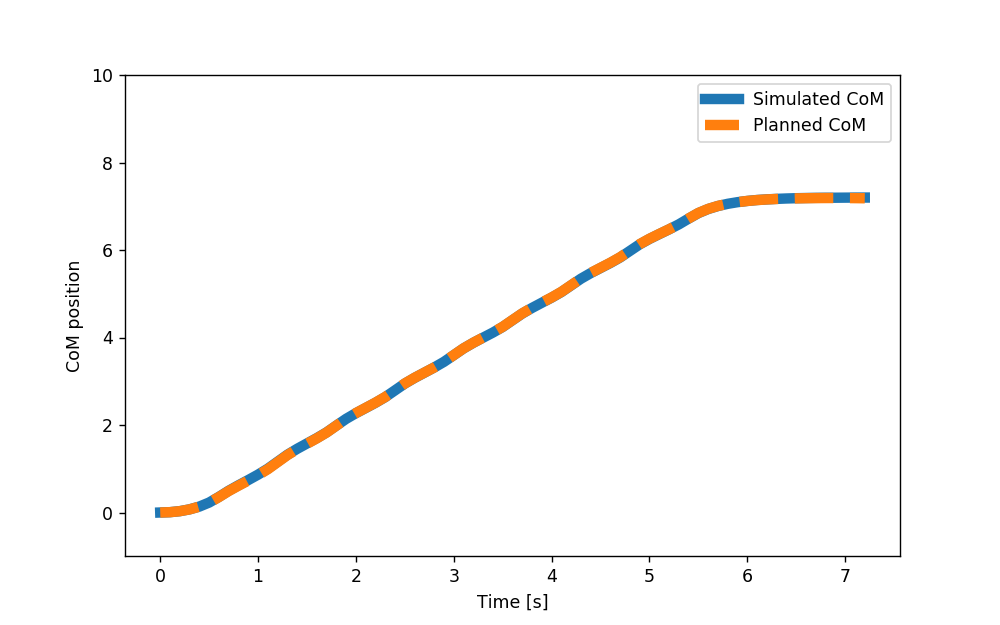

<IPython.core.display.Javascript object>


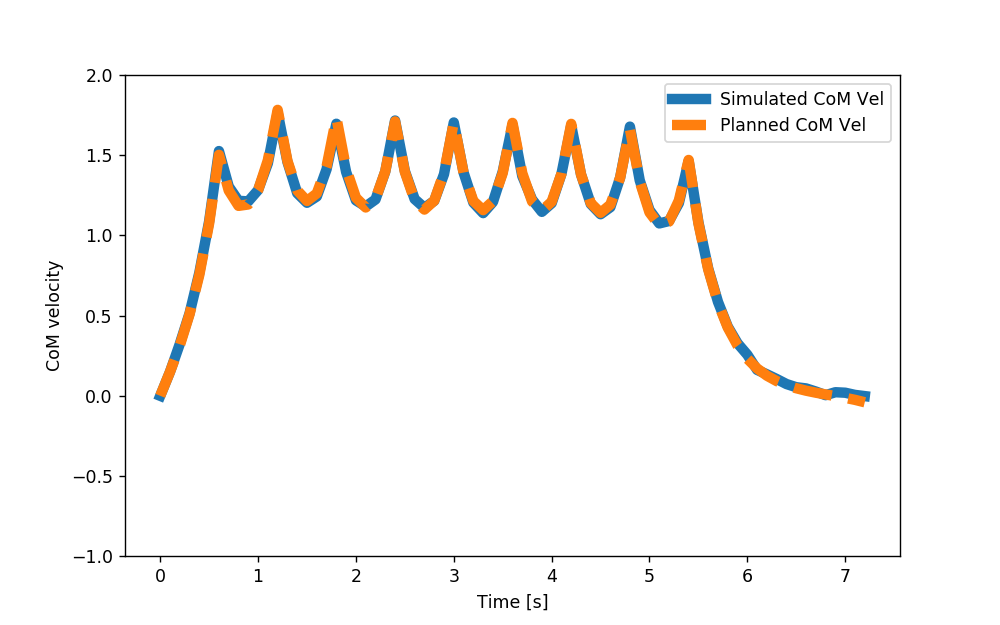

<IPython.core.display.Javascript object>


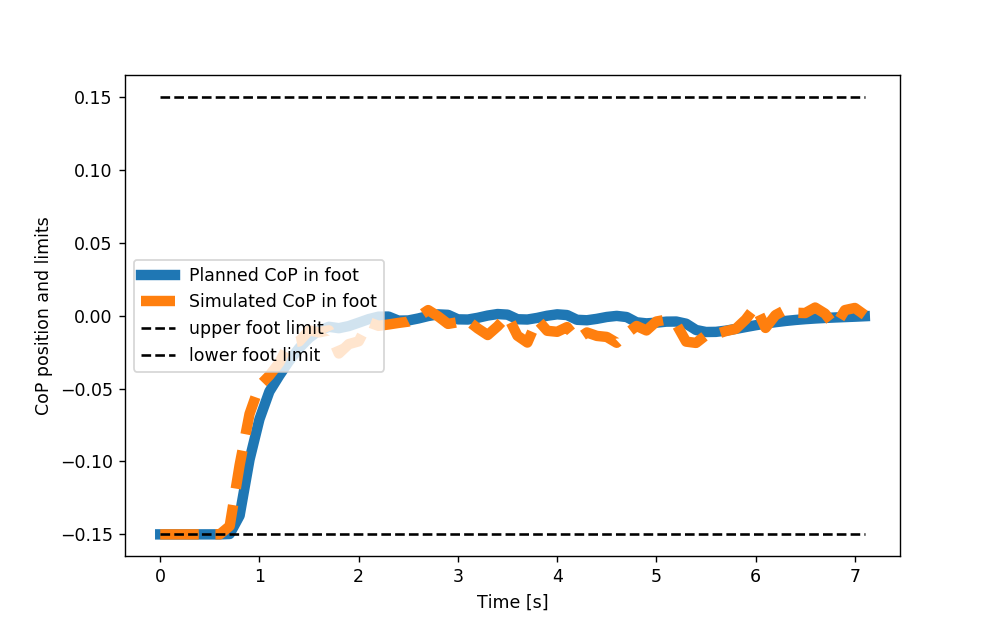

<IPython.core.display.Javascript object>


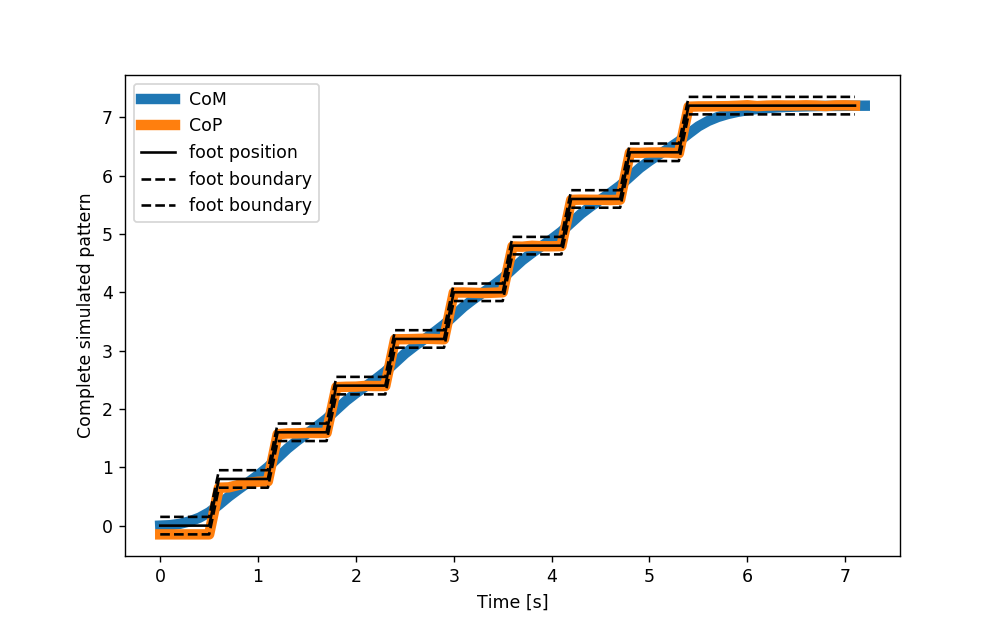

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABXT21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAyKZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjphAZbmOcdwu2wwaf+QclE2IUVk7ICD
zJkRF6bTnhVTeGhZaVM5t1tp76QeYwtZ9a21U6INDaifb7bmglsL3t7dC6pXiwg5f1OUZflnCls2
b8cUzgh6xu8sBVBoL8lMF67LzvgcqYSGEl2dE3iD8ie2JlOR34cI87FG4rqSzVaWBMoHv+oOk83C
aLpf1ZvVfbjxNitXMBd7s2PFnLui/jNqtI5VtcT0RypN2YqGAQK/vAlakoVY697k75hXQ6o/jB3i
oGZ4rFjVjzgwG9k84SrvmMB7hmg5s925KiAa4PKpVwy6amaCvFdQ9EzWeNkk0LeaWgFZ1Lj0gy6m
+jPOIpv7V/KYBs8KQlhivDmbhc8oTujsH9bujfwvuO4t+gDCKwtlFf3iiCTVJ0BjodvKyx+7SbAj
3ciuvis4nEr9D/TVRBfgnvZ4sv8F2q8ufLOJ1Z+XLn1TLI/YKC0fh/t//1ds638Mz2IvMIAyMv/H
LL2LUe8QXHdR9awW0xuH21o/gwXyoRUm6eVl3BeWkT9znsL6bx8M78F4RwMRwPShaFvXKw+OjKQN
vvrbFN0xHfIrdZz2fwPXanhGzpBz72H+F7RSNg3No6If4qTUUE4z8iRVncio2qfFDceoptCp/V8W
ny9PEoA+kO/JvB4atW/0MoogaYrGmvkKUVXQu/HnrquxIIHXc6VpQQzBKRrLcHx23gpMtN5sTzWF
MUHfwV3leHls2EwtxUfLXyY9sHYXcPpXuO4N6/8+o3IIMxP+Dz+b1vnEOwSOm3U9akOXax0D4Vpm
0fhbilCq7mGrHxB5W6ApADpBj35cVXt993rNdl5VbS7IicmX9p0HDoVwKH+q/oKrEQIUFzWV6p5z
PAM8KlupscfIIaGIsLRXxXwVTmUEuXXDfF52Pwryf537X2wAOCb6XJI6T72qpUu4Ch21IO9hbVXy
JR83wsuihUlloMq5uHyMM2mXPdBkpHWM9r3yPOq+R1gJZQ//fedGt2Sns8jx8+6qEDE3EftFko3m
+ue41aDQFPSdZ+p8UasRPoBnLdhmy9s62+wRbX5L6ASat/9BosWPoTHE1JS7PMmapDFGhJNGvsoS
p1xd1JxhghnfGU/KB7QH6ilRO0DrBvnE9gNAJuyejDNsnZUWBjdUlVWf9hJl3f2wlGa0K3jXKRC+
MwqVYEBHq8r5RtkXEFsVQpZk4g2i4j7Slv6INCnqRlUYAr2E/67LmAbxem63bq7qcIwRqk2M6rlx
bMqqRbujMnWtmpvoXn83fQGChmIBBHB4QtbDq98z/rMnKlgHUMStlWwDhEaJTXTq6edbrH2NdUDK
z7deeJuSn+ecnyMk0C/f4TDEkn88fGUh52fb0rycw11yBN3l0GCWogHaFoZdf1f1KEZWzLW/p4qs
yaCsa+oU3rHPumWeDETsNO6+qWXJI49IhGfQ3hB4/bQe7h1ulnY7YBiLUt0pk3CM4p5tBvNW2aN+
ZAJlYBuNSAFFSCdPyy1NdlEVsgHuxMJD13M0RAHAsJrX4v1ItfTSrnu+U3Od5t+syq0kAcUdlH9M
Ec1ivFePMJ3tRCQXnsUH4MtkADnBW4JyPuHXTVGIOsrLQ/UyTTxH1KSCu1KRlqKakOcP8XKrgagd
Jeg30IdWc3x2Z8522MPBwEpdpIV/96gqmGO+ax+fyWJLpBZR6cZUEx4xKlkmRUn/e5tbRm9orf7G
6gcRx1bbCJFXDfWtDMV9+IzXDPZzUzQJcwk172Npok0nXltmAIP/c8ituE1eP1HhiRUNnl6Tt7Ry
nFm0kBUBBTfdlmfEAl+z4OO3xBJnGAHfFhSgcy00zq5zuLFTXUKvTuFJrDk7jouf+oxqnCQEebeG
KIE01RPZ4w11tc2zOu8qCk1a9G2Wd2zoo9opNYzxwRn6kKemSZ+7GT/tryHZEw4jFquIQAFgojx3
XVf7kIcgAJ8AC6tSk2KFpx2avLuoTW24Gjz7TR1KkvXWKwJG2ioPVuUrghYUGdjzX2JbBvX00czl
4cwvsjZD9bZXCWVDxzvtwesQLhLpDvaPD0JTLgFWCInJfkIPMIn+39qrN1ihBFxDL/q4rOmrUrlz
61mqP5sTUIt0ruzABPN5vJmYRWYzB7xS68K60EanS4Gye+a2qZksDBqtabsMA2mewcnIBHDl/zIn
ohUVgqfnNRuq8jd4w3rlostkJMLNqoBsLf43AP/Z6K1od4xjn2AivgvsVf3bkPSzIdbEIU4TtfUq
RXDF0BjG2JyYr0Y91h2Tr6HD2Od//R6HoF19zJ41Cm8Z89udyZwbB+OaYpUZ5KpxnLFqb3P9VXzM
ZD+bKTsH1MXJP5QrUv1fTJjDnu0qXbpuQyRgC/0Vf+ZIRnDTjjWEjPVNfP1Y80Ei6aon2QHuyhcs
4sFOqZgZL7yFfrxRLEkPMJIO2ApPi6RkNPCqoXYvsIoobfGbnbafv1Ir+ED6jBaVdmS/PRYBVU0b
f5ep6LD+yFDLignae/YTjvYk8u4SoNo49ywnuYQ39TGvklSe0XweF5LmxyjbP1Tltu31gbZ8qE2k
mNO4kiunyiQS2lokRZU8svGdFmmF10h5+Ww+/sb/AwGkkeKHCbOM6yESu/K4ygAV7C5nthPlqpjo
BShUYByJzZwZg7RzrpThZ

In [9]:
# we simulate the LIPM using the feedforward controller when the simulation has noise
x_real,u_real = walking_model.simulate(x0, model_predictive_controller, horizon_length, foot_position, noise=True)

plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

### Part b)

After simulating the model with a horizon length 11, it was noted that the model although stable most of the time, it did fail several times. So a <b>horizon length 12</b> was taken and at this stage the model worked adequately, with no failure cases. Therefore, the shortest horizon length for MPC to test a stable walking in a noisy environment is 12. The simulation for the same is shown below &darr;

<IPython.core.display.Javascript object>


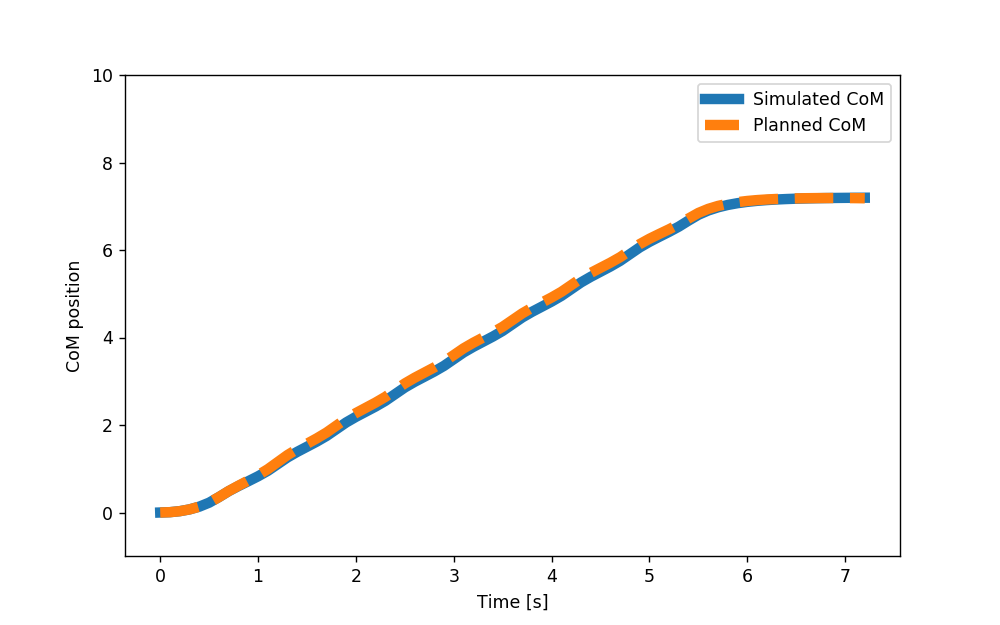

<IPython.core.display.Javascript object>


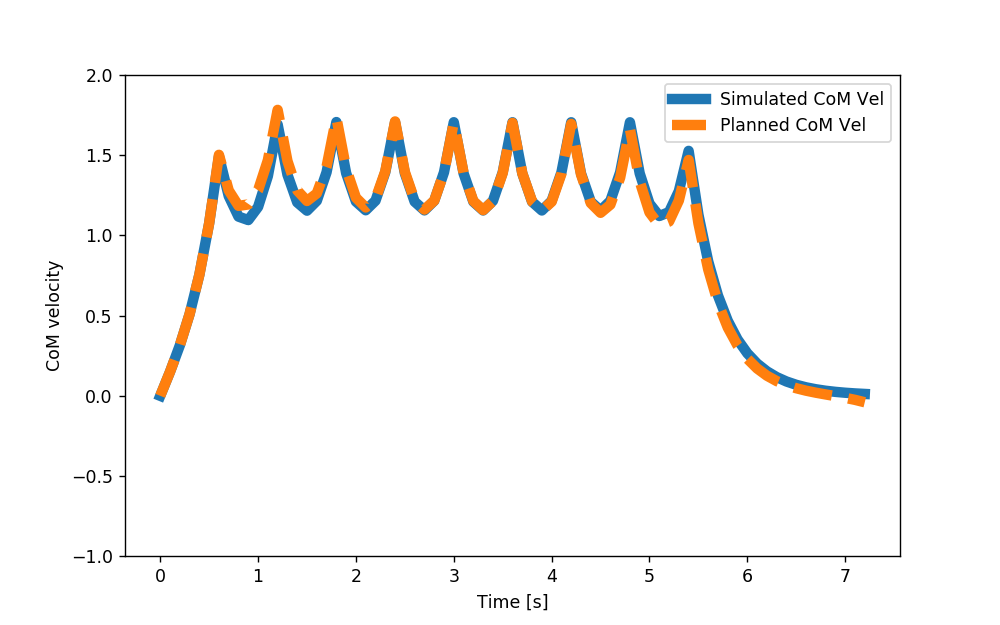

<IPython.core.display.Javascript object>


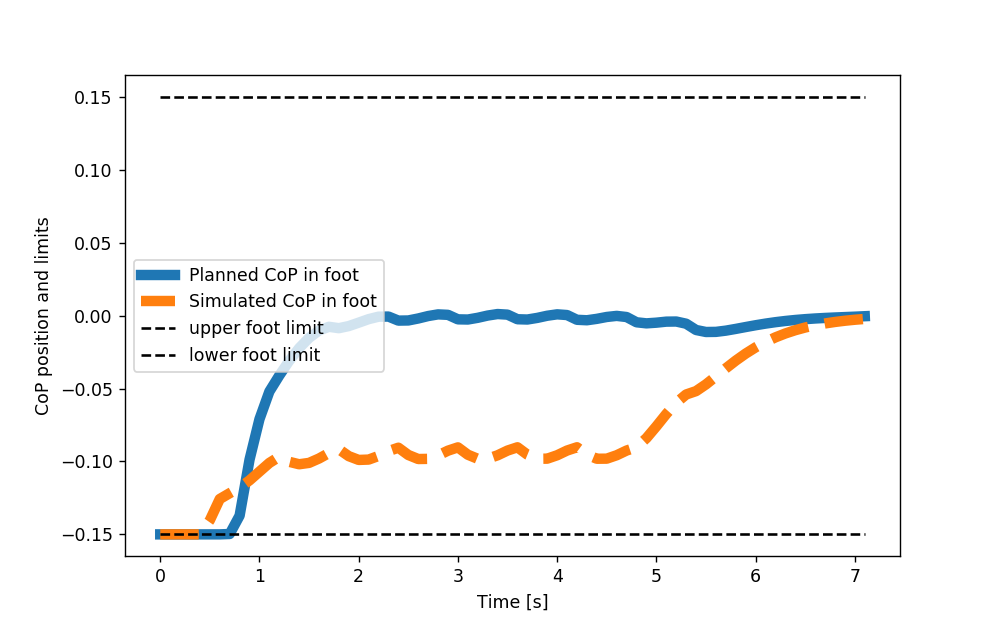

<IPython.core.display.Javascript object>


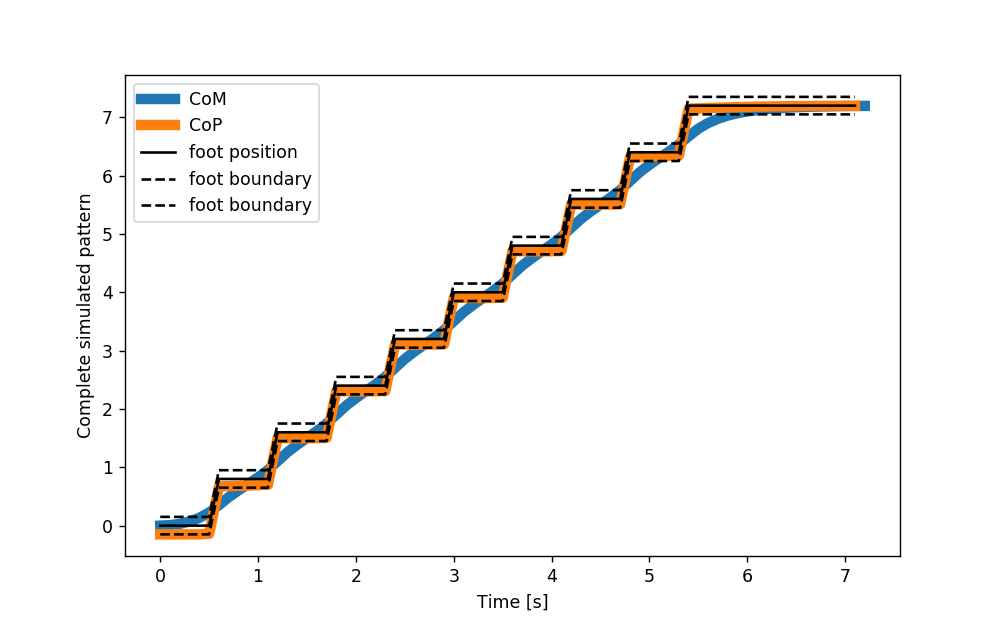

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABaRW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAySZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjphAZbmOcdwu2wwaf+QclE2IUVk7ICD
zJkRF6bTnhVTeGhZaVM5t1tp76QeYwtZ9a21U6INDaifb7bmglsL3t0dY5ySjbw5f1OUdNEPdag+
b8cVJ/fPsxyne8sBVBoWiTAFQ7Lx1OzrGObiJa/3QBqiJStzOz4YbTYrNHcC/ycjp9DoCmyoO65Z
yNaW1ZJ7CujUeCAhXR1WvqZgOrrfOqc++WdGQMEdpHm2THuNSVHKm/dWHG5oSui2CLu+Zoa2myG6
JK7aM0LXqFvAeN7NKYliy3RsncHYjnfY58NVujVr45jCYqVqyttIJLj65vqFTVnXuZMEYAyEUZwt
0tjbr0l2/aG+3hVptkU/qDBVoOsWwlleHM3C56KYE1T7y0Prig0AfkNzZI1fxgU1RtWZgktk+tic
nJXKV/ZpFfRS95wW8Ff0ZSi21qaqIL8FAjk+c6qDEYAch96ntX6Hq/NGhlgdHb4MiP3P/5XkhvP1
o9ISKgkOOVw26DjsURt5ha3iLYhvVx3e97XFMsm17sXLJ/BgvlQTYFadLPz5xJav25guP+27ECX4
nuRgIilBsjiBoYVh8fG0s6e1G2KbpiO+RWrHbGRvPyqcjaoNu9QdIqAz5fsM/evRD/FSaigm7qpl
YHZBfqDaXCKGVim0Kn9W84iaE8TQDiQ76i/3dXdzZIVRQ/UxQNLfIsoquhd2BHcVdiQQOu50rSgh
mCQLMKCmqwhNvHObzB2G3wh01FNhcqRiH0AsYblKJ0c5Me2DsLuH0qunVtZv9BWHK+RshRa0OWVv
nEOwNuW3U9akOXax0D4QuiGsXh56rzGmkD1oh5W6ApADpBj35cVXsKxRBJxBNhaHOoNKWmJzmesO
L80jLSdy/pyxZai9rK9U85ngGeFSonouPkENDEWGmFtGXHacGZ21xC404WdecxSwrb5uGj9Hd8nk
kdJ97Vp4VHFvYAILSLeqozUHmP5wx5jg3d8r182BtSlELIufaVNoq7lH9yHZNNwt/3/dP+adx61X
HZYCdnFTBvpz8jINHCwCB41p7dZ/bnrRc12pWSyU0nzftrzGVuBNaYUHSuw86yIVuF064SUO18+a
178GG5K0nWBF+0iCpv9BWAZ3xutczQZoLjhXe+76LjjimlJJhFxNQ+lFS3tgC20NWKbP2mDwj/tg
AbWl0YdcSzwdrGwKNFDLn/N7+LzLpesfHSpPrlU3DP139pOn6Hk3UWUZPum955D12XMA3i9N1u3V
6orEbCtJsZ1XLi2ZVUkVsKsM7qwad43QOFzQGChmIA6u7rfOq98z/rMnKlgHUIhEQM+VuXGIWkeN
KVnjrH2NdUDLCgJ1B8GB/Re2vu4kGU7ectlqoSHtWLcCoTBp+12zqFrl5jrjWfOFo9a3HLk4APL/
llUV7Mtb9uc5F2cFY15QsOi8X7g03sA4Fcfg4EUP//ZNtyrKf2q+q+6rk8rd81CTHM0wCnOug5EI
3WXAT+UgdJOoYLUd5IIoTSCwu6BlxPOzm7jgCJ0fpmRjgizN/lUlsO1d0zP4jUM7o6OQq+jWDISF
y4yRjqwalD37gY/t/S8+Q3vMar8Wskh6CWr7hcFfwZbIRLH46eA/Q6L/nmm2MOwFdfiS/0F+NlXb
Kw81Wz7MMPeOnbpeQcLsj5Sz8GOre8Y7M+c78qAO3mHg4CUvHJRx8NyysSf6zmX+rGeD+zE3e9lG
txX42WORFSf97m1tG7lE48UswyymOrbYRIq4b61oZivvxQPiCopoRVxEuYSbSIFqM7aCcUoGFOM2
rgTojcR3S+VIf6xMnKqcQDJ8h1GmtZ6qbSWj/Zk6wQ6+JNdvGzGSSt0jyXJAQwqNlQSMc2qxqhrz
RCP6PmCyHgyz08RD6zpiqmMoIMUhOGdmUW4a9AM/xKEnOEyq/8iMRx7wqEuOvq8BFfC+1TV8SQ4X
4WWY0nO5gc1D2is11SgBrOVY4pOB3GltmrM7qE1tuBo8+00dSpML5fvJabA2w7qfW++7BlfitQJE
ie485NHMqV301YcNcXw8Tyqboap324PWIFwl0h3rbh6EplwCrBETkvxs+6rb/DjfUd3+dTd7RxaQ
UYDYGEzTINazQbaCvsaoiKu7MAE83m63IOD1n/OImGXs+6nhTH579tVq4gCfidIeb+7GxBcXrouL
USloX9vJ/2sfhbaRIGPnpu+Da3pIovJeIY7MUSdhZSEEhFv4exFciDWyvT4zknh9c4MZAfUkl5re
CATIiNaPXqNYMrnisU+Cys3SsTLcTLc0EIMpVI8av4MU+TgxzekkH45Y1PRW8I9k8OLk8bkUEdaA
tYSGKXwAq91ro956jsfONV5Hogf4uA/ceccOVnehiPUrPNCSNzz2QEGRqSz5wkTDA5J/78q+FSPx
izLMnWcDShTVIzKxN+7BFjig7qyP1dkLas4aEAjA7ns8vcj8IF7u26Mp0/5bE1TJITv6C5s1ngZI
nL39zUQYo1PXHsKGXFBO1FpSMeciHwCjkg0qM3LCe5hDf1Nhu4Vcz2VB4XkubzvVW83I1afJNvyk
37jeRo07iSK6gVJYIkdMlGQpVK19IUn1fUkHn5gtzbEX5sNp+KxHMHUMZ1kIleTV5Q4nl7H9puM1
lqpjoBTrfQlefzbkbxgfc

In [10]:
# first lets create a walking model
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(step_time / walking_model.dt)

# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2)
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))

# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)


#Defined the model predictive controller
def model_predictive_controller(x,i):
    
    #horizon length used for the controller 
    horizon_small = 12

    # now we can construct the optimal control problem as follows
    # we will define bounds of the form G_bounds [x u]^T < h_bounds
    G_bounds_new = []
    h_bounds_new = []
    # the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
    Q_new = []
    q_new = []
    R_new = []
    r_new = []
    
    for j in range(horizon_small):
        if i+j >= len(foot_position):
            current_foot_position = foot_position[len(foot_position)-1]
        else:
            current_foot_position = foot_position[ i + j ]
            
        Q_nominal_new = np.eye(2)
        Q_new.append(Q_nominal_new)
        # we want the CoM above the foot and 0 velocity
        q_new.append(Q_nominal_new.dot(np.array([[-current_foot_position],[0.]])))

        R_nominal_new = 100*np.eye(1)
        R_new.append(R_nominal_new)
        # we want the CoP in the center of the foot
        r_new.append(R_nominal_new.dot(np.array([-current_foot_position])))

        # we create bounds for the CoP location
        G_bounds_new.append(np.array([[0,0,1],[0,0,-1]]))
        h_bounds_new.append(np.array([[walking_model.foot_size + current_foot_position],[walking_model.foot_size-current_foot_position]]))

    # now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
    x_new_plan, u_new_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q_new,q_new,R_new,r_new,G_bounds_new,h_bounds_new, horizon_small, x)

    return u_new_plan[0,0]
    
# we simulate the LIPM using the feedforward controller (no noise)
x_real,u_real = walking_model.simulate(x0, model_predictive_controller, horizon_length, foot_position, noise=False)

# we plot the resulting motion vs. the motion that was planned and the associated CoP
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

<IPython.core.display.Javascript object>


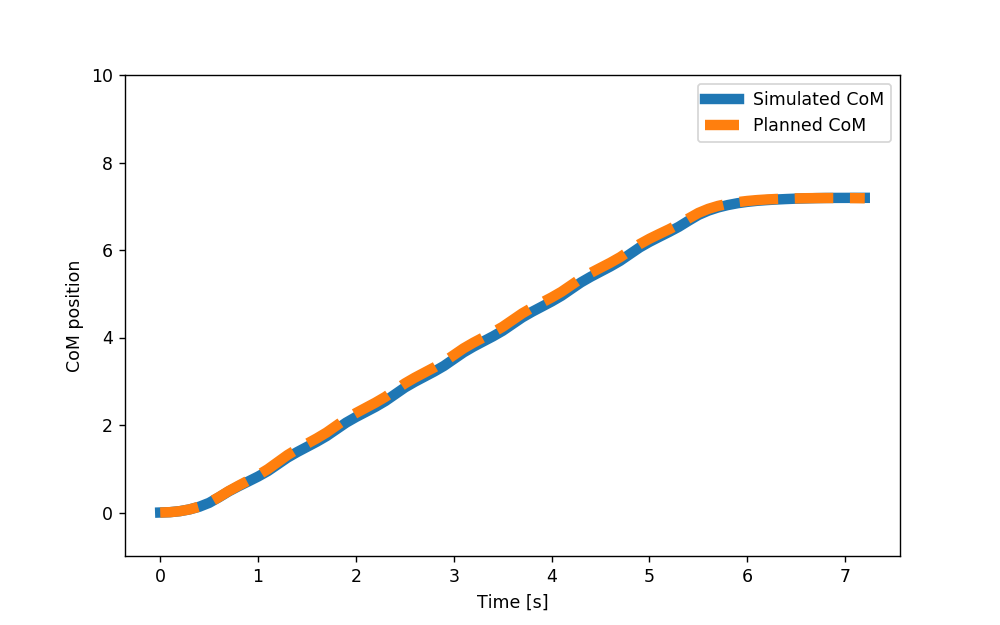

<IPython.core.display.Javascript object>


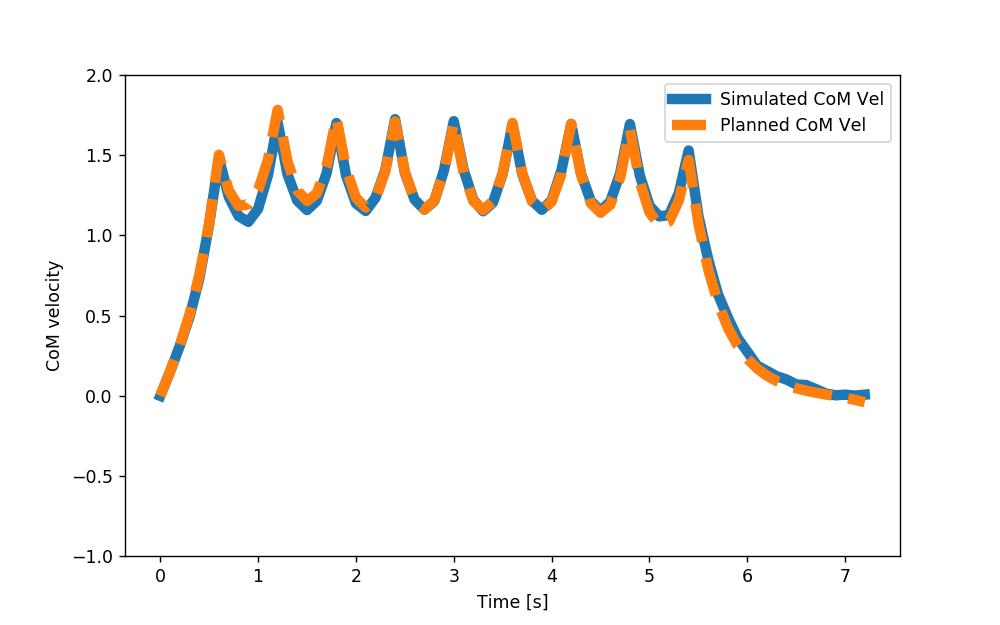

<IPython.core.display.Javascript object>


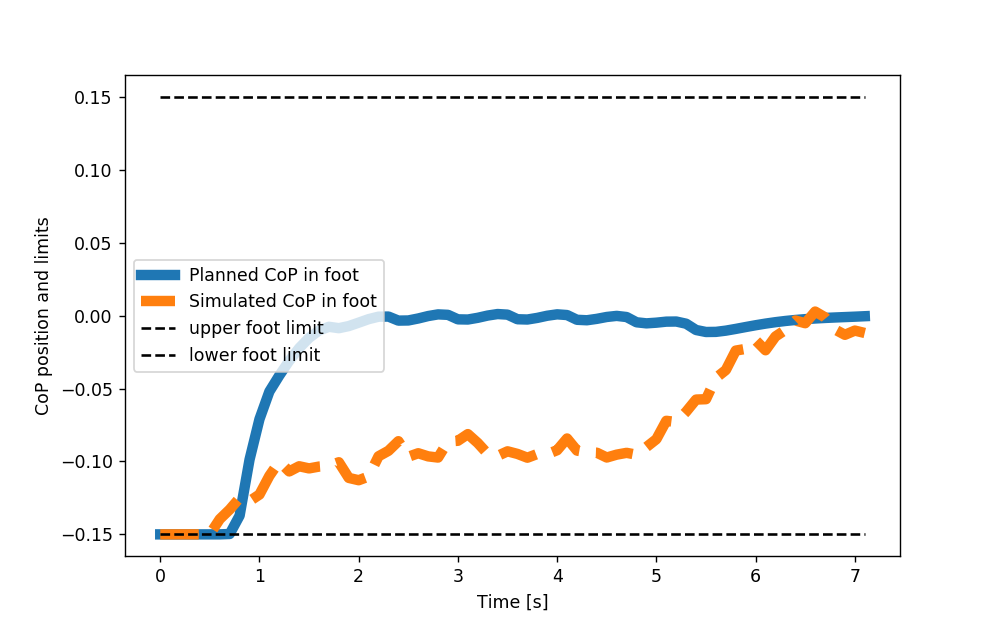

<IPython.core.display.Javascript object>


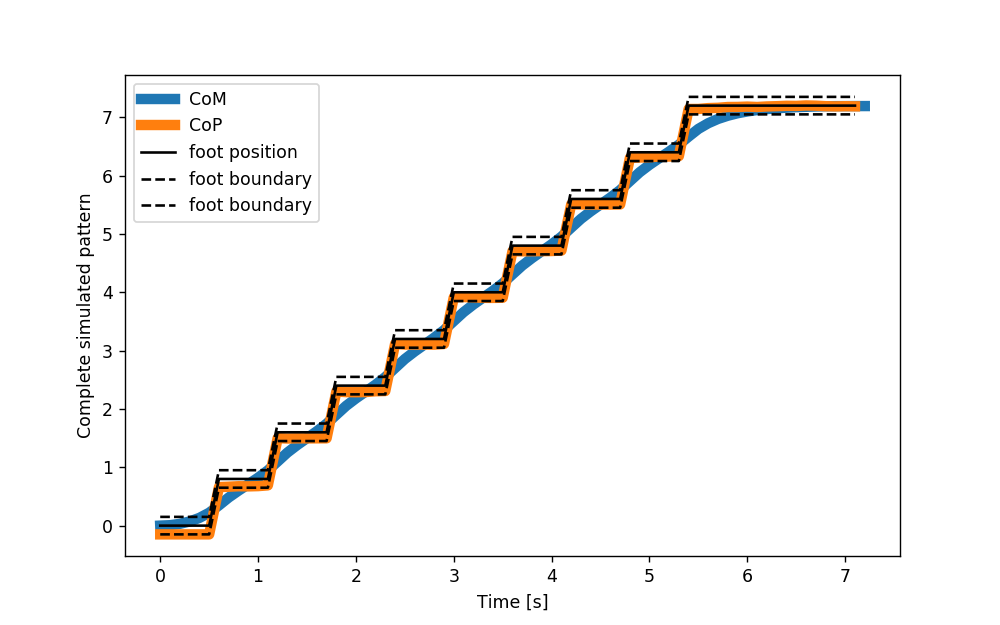

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABaMG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAyAZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjphAZbmOcdwu2wwaf+QclE2IUVk7ICD
zJkRF6bTnhVTeGhZaVM5t1tp76QeYwtZ9a21U6INDaifb7bmglsL3t0dY5ySjbw5f1OUdNEPdag+
b8cVJ/fPsxyne8sBVBoWiTAFQ7Lx1OzrGObiJa/3QBqiJStzOz4YbTYrNHcC/ycjp9DoCmyoO65Z
yNaW1ZJ7CujUeCAhXR1WvqZgOrrfOqc++WdGQMEdpHm2THuNSVHKm/dWHG5oSui2CLu+Zoa2myG6
JK7aM0LXqFvAeN7NKYliy3RsncHYjnfY58NVujVr45jCYqVqyttIJLj65vqFTVnXuZMEYAyEUZwt
0tjbr0l2/aG+3hVptkU/qDBVoOsWwlleHM3C56KYE1T7y0Prig0AfkNzZI1fxgU1RtWZgktk+tic
nJXKV/ZpFfRS95wW8Ff0ZSi21qaqIL7ra1l7X6mCESNDj+9LpPK6oVoiuHxMUg88qa///+lui/df
rDt1HHGFA4FbuONA9uERsH9RoBHX0OoD9FxpbJnfWoR06wZF3N89Ouax2Lkr5Gma1rLCAO2ZMbKP
03YTMWId7KtO+zLecD1kpX9h3p81Gjc4ECZNCk1v8GFyz0WRK3oVR17CEzg9Fmh3l62zDUIoBcqp
NKANskVCScUUKn9W+dTBCeIwCXfgKWmTw3MotIZRRA0xWNNfAO8qkUWxvreVdiQQOu50rSghmCRH
NEtMtytd8XMnWywmodeML4Olnxo7o+raYW4qPlr5MevBISjqsXmmqt5P+Lg+1ZGYn/B5/N63ziHX
VdKjZHreC6BuN34LczaPwtxShVdzDVj6Q8rdAUgB0gx78uKr5jLNazXZeU0fzqDSlpic5nrDjoe/
UsmH2ZmHwKvGkPuv2lwHQH8VhDzjlJtGhiLZTC2jLjtODM7a4hWVudj8K8n+d+19tXLgm+lySOk+
9uairr/k6gNCgi3qqM1B5j+cMeWYN3fK9fNgbUpRCyLgIClPaZmUs2wXrw0vpT/tmxE2Zh6DU/iD
br2QNY2O80cLAIHjWk9iJGbwIe9BnWpQl2Dm0ZWYytwJrTDOYh4y/+O3P6YysdQepy6lC0yq9yyv
ktwI/vM7rk7DVLWJYkUG/Z6BgOfvqKnKGLj4jHfNeJOFXZ1crezuJQGQqvSQsf3zmcaifnowLIb1
dYMXDt62D0rcEI3mDmdRRgsul6x8dKk+uVTcMdD429If1G8ekso6XaVbW8h67LmAbxem63brMMBI
thWk2M6rlxbMqlSL2FWGd1YNO9ncIbvoDBQzD853/KEkLCDtqvWd0FvFlEtFEDPlblxiFpHjSlYV
FljvIYBV9OfEsIYf5HjnWPpRm/tSAttcWv+UQJxKYhX+FqpBt6N6P0l/6BN+Cq8HSUqV8tf0kn+n
h3sxPUH6dnyyYYsICxTeLgz/HXyVY0CNPjKE+f6/Ea5HQaEmrJ22J6fA39XseA0/OJ0Ce5qIRwOq
dICp/AHQBeRYwE8CCnA9VATnOFh6ECarMRL3/j3cC+8PoH/JAsCLT3o/RcWAvjebaYVsVIzsdMMr
pzTGmshi8Egn/HEWNSPzrXmU7rpNZFD5RyTuEf4MtkLwBx9Pp9mjR+xrDbGHUJ0/uf3QVK+uS+ON
0h57/MMPeOnbpeQcLskdFj8GOre8Y7M+c79N0xxnDwcBKXSYq1+MG4IJP9ZZ5/M6RPv/pCRxlGv/
m6g/UoipJFPHa5re1OT04uoHEcdW2wiRVw31rQzFffjLPxjxRbUlMkpaYslHMB6aU1WNJ/MLDukB
jB1EXKKBA1mjm5wowjW7Bi6I3pYGLgvrDJUDZUPCt1kYVPbe3F6Z+ZNTkFWC74U7Zu/KMIRULBBw
XZ71E+ecWZrxDUZmxMzXARpHKtzMgNKJdf+xieG909ErpKP7sZP+2u5QO1lTr+nHr2XhU+Kuq90V
634Be3SxwY4fdihp8nGg3nUTlGFcblVK6AyUWtrFYEjbUtH0P+t+69N4ADagSJE9x5yaOhf78wvs
jZD9bZXC7dcOtznjeVuf4VxRSoKiFBbMsaUVdx++jslh3v8ON9R3f51N3tH4+ris6atSuXPrWac/
myau2hwXM3faxeP9A8BNpehAM7026iYziniHZv4zclGnL1Wzw8HKWPoWFr8zI+zbf2fNIt/8MvzB
GH7bryZk1VIiMMUV9cJLB+sEDlO0Pzx9TKHaK86m/1lZJauAS1C9TGQH2mJea+iRGydZjk27vsGc
zxVQghZWbpWJluJmDuWcGsh0fTX8FEklBZTGG+TBt1hPoyZp3Wikk2Vspo7OtAWsIjHe8AYkJ3I9
BbWMfYgPkeiv2GkEHsUd4kahKFqGSs86VqQIop4xxa8MN3GKN5BrlXrCzQ+FdNYNQpKlTMEXD9Y9
vJPh3c1d8Wi/GDKWgEjoP/4WavZW275HLkZTuGO8v78J5JkkJ3tEcVCzwMkTl7+5qI0T1ztPpv7D
pJ+aVQVMH3Yk8u4SoSytl6KiDWu2Kd2GBjk9ovg8LyXN6FHX+bkatPkm35VpUJtJMadxJFdQeSkU
tLRIiyp5ZeM5yitVFkHn9LUDdeL82G0/FYjt/2XYFZ61eTZ5Q4nl7LE/uM1lqpjoBYIkLVefzbmf
IvPuB+6papVInoV+hkcFT

In [11]:
# we simulate the LIPM using the feedforward controller when the simulation has noise
x_real,u_real = walking_model.simulate(x0, model_predictive_controller, horizon_length, foot_position, noise=True)

plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

The difference is however clearly seen in how the Center of Pressure position of the simulated model is closer to the rear of the foot (heal), while the planned CoP is very close to the center of the foot. 

### Part c)

Since the minimum horizon length required is 12, and the step length is 6, it is clear that it is required to plan <b>2 steps</b> in advance for the controller to make the system adequately stable.

In [12]:
print("Step length in terms of horizon length = ", iterations_per_step)
print("Number of steps Equivalent = ", 12 / iterations_per_step)

Step length in terms of horizon length =  6
Number of steps Equivalent =  2.0


### Part d)

 Seen here in the plot below, the executed control value is slightly different from the planned control, as it should be, adjusting according to the noise.

<IPython.core.display.Javascript object>


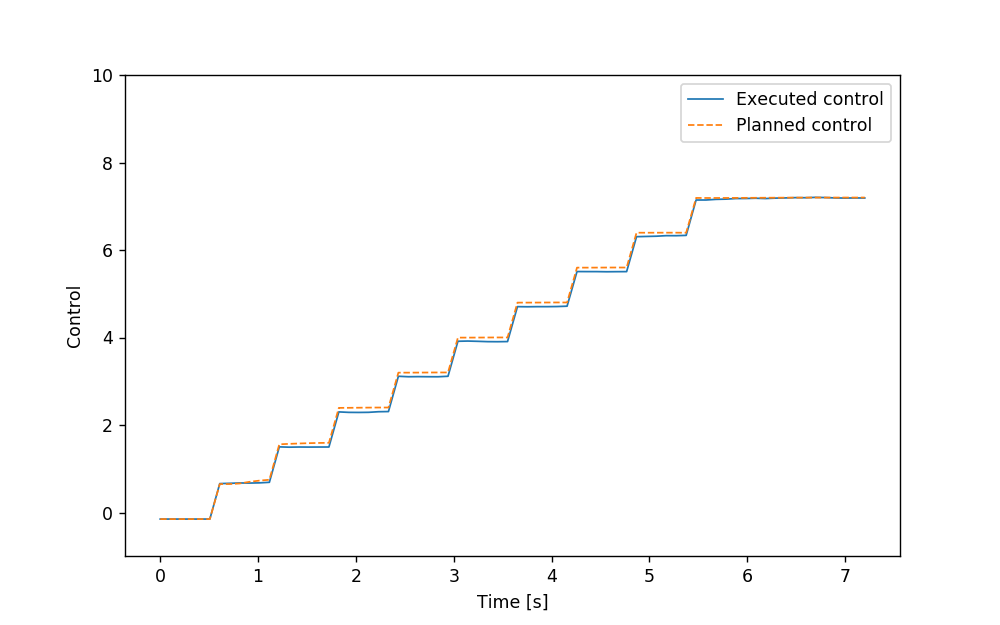

In [13]:
time = np.linspace(0,horizon_length*walking_model.dt, len(u_real[0,:]))
plt.figure(figsize=[8,5])
plt.plot(time, u_real[0,:], linewidth=1, label='Executed control')
plt.plot(time, u_plan[0,:], '--', linewidth=1, label='Planned control')
plt.ylim([-1,10])
plt.xlabel('Time [s]')
plt.ylabel('Control')
plt.legend()

### Part e)
*please check notes between blocks*

Checking the behaviour of the system with different weights in the cost function. 

<IPython.core.display.Javascript object>


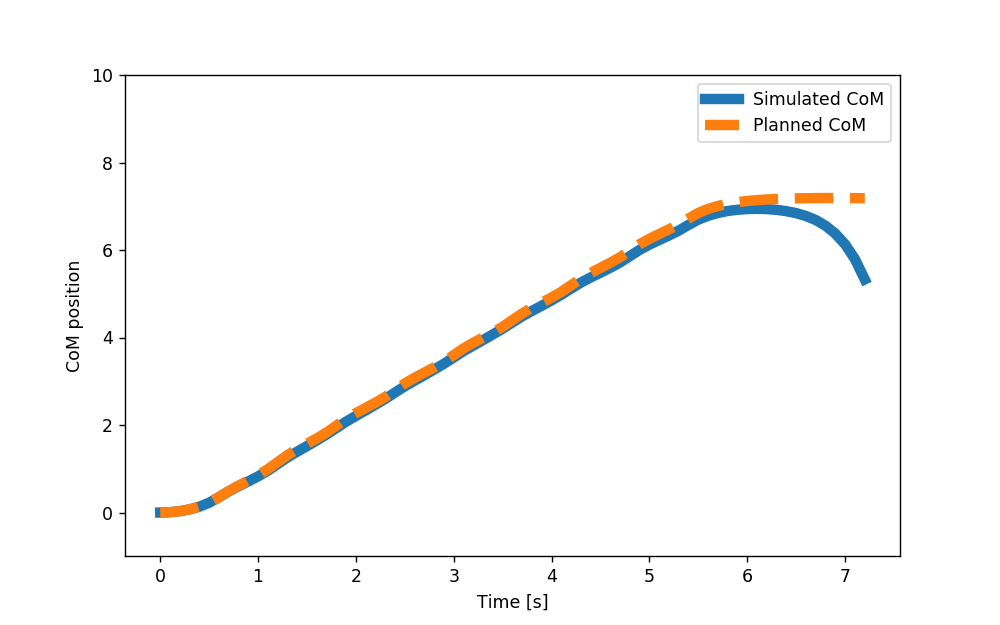

<IPython.core.display.Javascript object>


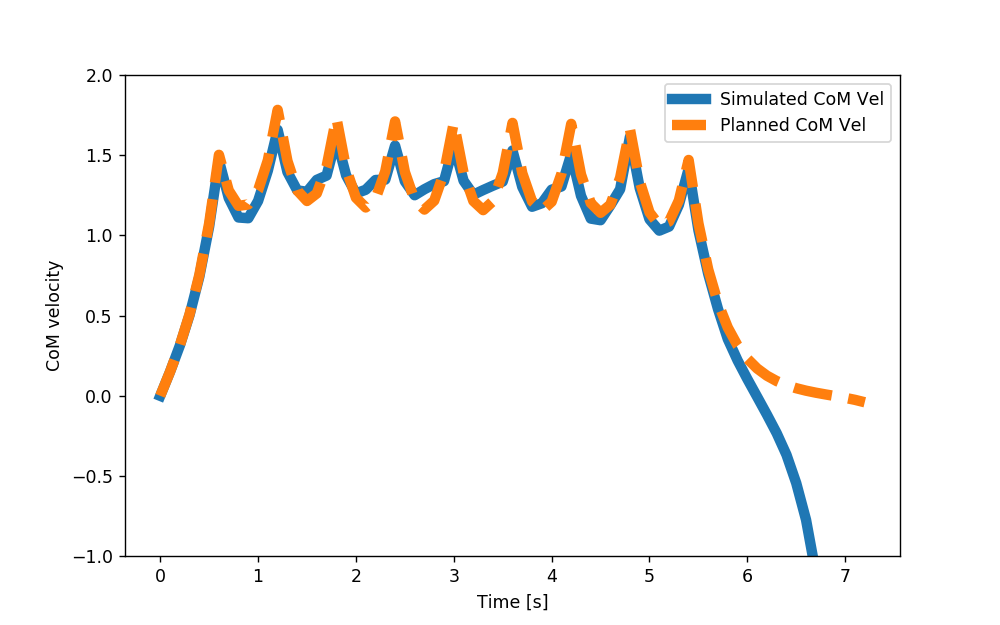

<IPython.core.display.Javascript object>


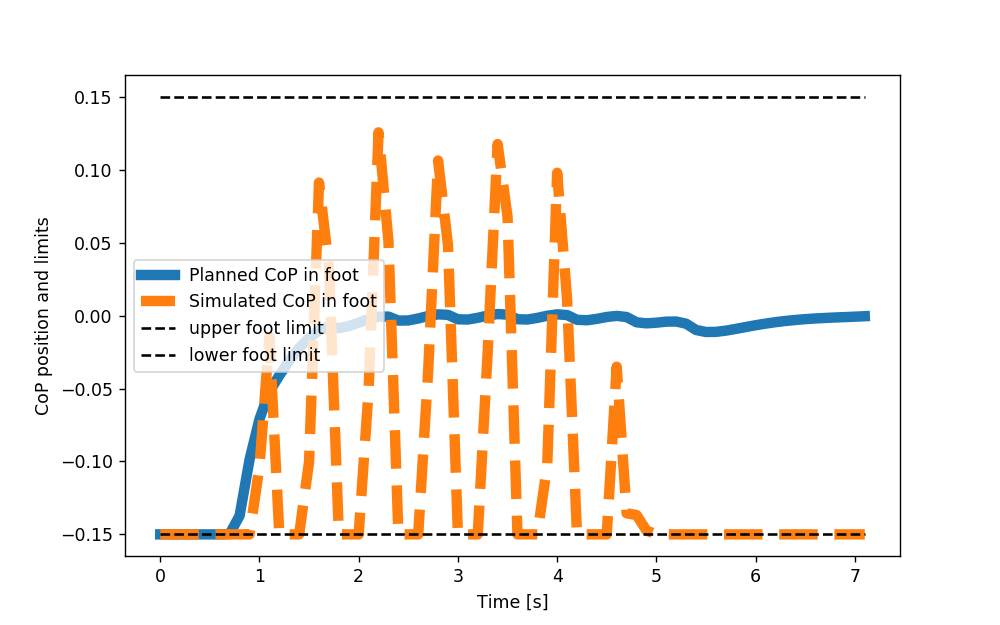

<IPython.core.display.Javascript object>


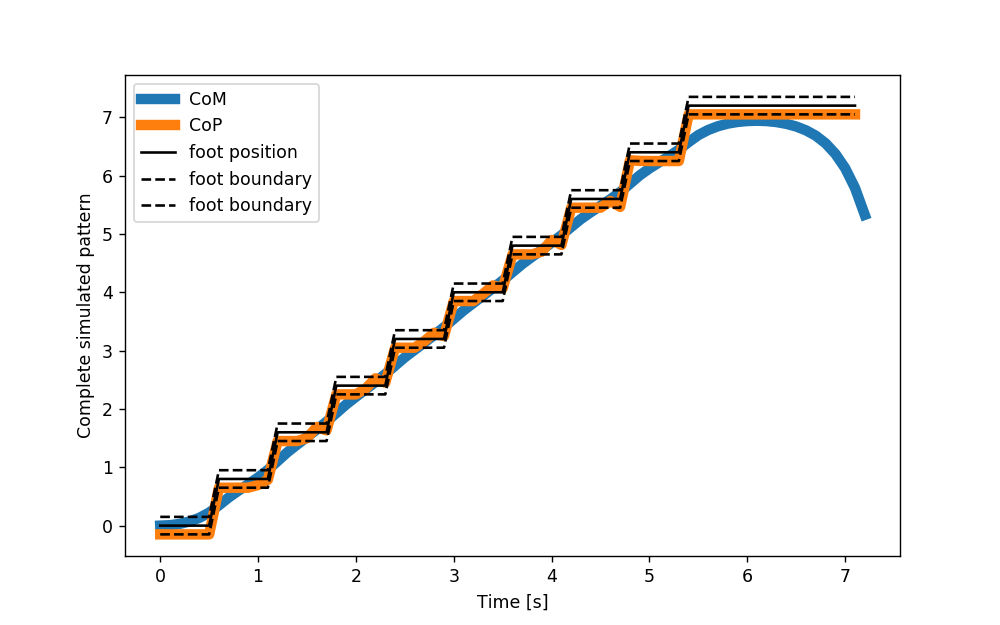

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABkxm1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAxuZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjphAZbmOcdwu2wwaf+QclE2IUVk7ICD
zJkRF6bTnhVTeGhZaVM5t1tp76QeYwtZ9a21U6INDaifb7bmglsL3t0dY5ySjbw5f1OUXNEPdaeL
j8cVJ/fPsxyne8sBVBoWiTAFQ7Lx1OzrGObiJa/3QBqiJStzOz4YbTYrNHcC/ycjp9DoCmyoO65Z
yNaW1ZJ7CujUeCAhXR1WvqZgOrrfOqc++WdGQMEdpHm2THuNSVHKm/dWHG5oSui2CLu+Zoa2myG6
JK7aM0LXqFvAeN7NKYliy3RsncHYjnfY58NVujVr45jCYqVqyttIJLj65vqFTVnXuZMEYAyEUZwt
0tjbr0l2/aG+3hVptkU/qDBVoOsWwlleHM3C56KYE1T7y0Prig0AfkNzZI1fxgU1RtWZgktk+tic
nJXKV/ZpFfRS95wW8Ff0ZSi21qaqIL8FAjk+c6qDEYAch96ntX6Hq/NGhlgdHb4MiP3P/5XkhvP1
o9ISKgkOOVwo7ywxerx9xbb8DhAVH8Qb2trh1Q5kr+j8jhKSO9e/JlAVMs/WENr0z/phay1bgGn6
aARoM5gNtA7GahmNSrjNaEcTsHtabcya3HbOS8hi+XB1wGG55utXdt6Z+ve5UQVq8cXZJw4eVPDe
RDTbvoKN3TGNQ1njNl35EWhgMY7dWoiecWiu/Q+iiFpi8ag+VzAZMt581Mv4R4KqYEtYp5bvR4sr
EMZgZOAlS203mNMNtd+oO/gpN94y9QCxhuUonRzkx8hOLkwyirFNViUf4sLrtZ2if8Hn83rfOIdd
V0p5Uet4LoG43fgsKmcNC3FKFV3MNWPUDyt0BSAHSDHvy4qvL1iHrNdl5TPnOoNKWmJzmesOKjEj
LSdy/pyxZaizrK9U85ngGeFR8HguPkENDEU0Ck4r4KpzKCXLrhVcA+CupAU+8NRfudhXG+TySOk+
9rGqJy5TkYkC2zPkSj5vhZdFCjEvN3fK9fNgbUpRCyLgIClPa+J5jhwpbcIFf7/rzE9O49arjsvM
bWSn5JlG4aOFek34/4O4r9N/eMZ0FRK1HdZ4Q2QDFvMejaYZz9f/ysK/6Dc/pjJTUgwdjWA9zgYh
fXyW4EhtdFkgKH4m95lagoUQKEQzC4p+sQmbnWQowT+F4WSNktZ0oqWhngdIHvOeu/sKk8NFE2rX
HTauswAAKfTc5NCUFBni2yLiC2KoUsycQbUTvRt2K9NML5SUXYgT/tvIeuy5gG8Xput26mf5N+n0
XdjOq5cWzKqgGKINV25K8X08qRfFtOR92LPT3lbDO5hB21XrO6C3iylN4iBnyty4xC0jxpSrsdee
ca6oGWFL1IwE4B/Re2vu4kFyZectlqoSHtWKxeBmkfeRb4UNdcgTd5dTcJdvMJnHJwBfJ++kMyMj
jKGXMQEXBWNeUI3avF+4NN7AOBkd2tGuv/+9xTWH0HxqiY995DZyvdw63O+0F2oj3fEY5sQreYNW
0o6n1bcOKQoEGJGLKTMCyjIOnUv4awNlEVsgHuuk//hIOHtBmpi/JAtmwF8l+Ptc8dGsoaLr1rXN
v1mVZZbWJ+vAFDLe5Q7aqTFBfJe1EJBeexu/gy2Qp9JmU5BmaMvqmqMQdZTS7fUyTTxH1KSCu1KR
lANAewFoTSfVwNQOjCXubRd7Ob47M+c869lFOwZtICUuZT/jzibgR0H1mbl7TgTopkk7MGCJ1M55
TbGvApP+9zVkmv4El1BC3LhzV6tthEirhvrWhmK+/RbTAtIr5cs4VvsuyvTBJTUbl9viPGGGW9AH
KQH0ZlWcsMiTRHQoT23w67j5AWyPl7DQ6g1U3karTyOgPv42/XNMGTnEjskwmc1RkQmB5Vh3VqS2
cSMhPwTZ4UGqEjPP8ncA09eFVRstLOIBh9DxPvIDafS6H1UbC5ejL/djJ/218CEzzXHcNkQYIIME
Q4J/oDPM2AoVXhvcziAYCLt7lURQ7NUkr7f9jBbKnlvQnwDuS01mDTuoN5915LMLRmTFPQe485NH
IIIz6asOGuL4eJ5Z8nmOd9uD1iBcJdIeA83IplRPH/py3H76Iusjp/7f2qs3WKEEXEZNpBRgNgYT
NMg1rOkVzR/xqYvZ+QoI91s3WrdzpehAM7026iYzinfx7v33yY03j197ep8Uz4ImxjtG5Rb2jrf8
zr10duRRH8Vd9of6jOqhQRuLOfrBA5TtD8FqTt8sqcXpQ80bSHJPD65wYyA+0JcnbbwYr5K60erU
g82WL3Dlip9jDhZsCO4mYMFfx84UUrNUAoBTaC0lQMa3pZtjmcFcagEZwaZvXmObbsAIj4jIXSr4
zgDoP2yJCLxIwfI857b03Cft2RtdqWJp/CcN9KZQeZ1K4mIN7hIHY42MBrDQOiS0SZ0jc5sNyhi9
DtEMcNLsWDaosyTEkPMJIWdzs3i6RkOEC5l/YvsIoobfGbkz3t/fhPJMkhO/mnPYWeBkicvf3NRE
ieudp9N/YdJPzSa7Jg+7Enl3CVCUbY+WE9zCG/qcBfQq5nsqDwvJc3oOdEZuRq0+SbflVlQm0kxp
3EkV1BCVIaSkZKMhSqVr6QtT2KVse/tn9C9ovzYbT8ViOGu0YzrIRK8mB4j7Uignlouh+EKxhsfM
InwfGV6C2uGYH3A/frtjf

In [14]:
# first lets create a walking model
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(step_time / walking_model.dt)

# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2)
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))

# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)


#Defined the model predictive controller
def model_predictive_controller(x,i):
    
    #horizon length used for the controller 
    horizon_small = 30 #horizon_length

    # now we can construct the optimal control problem as follows
    # we will define bounds of the form G_bounds [x u]^T < h_bounds
    G_bounds_new = []
    h_bounds_new = []
    # the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
    Q_new = []
    q_new = []
    R_new = []
    r_new = []
    
    for j in range(horizon_small):
        if i+j >= len(foot_position):
            current_foot_position = foot_position[len(foot_position)-1]
        else:
            current_foot_position = foot_position[ i + j ]
        

        Q_nominal_new = np.eye(2)*10000000000000
        Q_new.append(Q_nominal_new)
        # we want the CoM above the foot and 0 velocity
        q_new.append(Q_nominal_new.dot(np.array([[-current_foot_position],[0.]])))

        R_nominal_new = 100*np.eye(1)
        #R_nominal_new = 100*np.eye(1)*10000000000000
        R_new.append(R_nominal_new)
        # we want the CoP in the center of the foot
        r_new.append(R_nominal_new.dot(np.array([-current_foot_position])))

        # we create bounds for the CoP location
        G_bounds_new.append(np.array([[0,0,1],[0,0,-1]]))
        h_bounds_new.append(np.array([[walking_model.foot_size + current_foot_position],[walking_model.foot_size-current_foot_position]]))

    # now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
    x_new_plan, u_new_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q_new,q_new,R_new,r_new,G_bounds_new,h_bounds_new, horizon_small, x)

    return u_new_plan[0,0]
    
# we simulate the LIPM using the feedforward controller (no noise)
#x_real,u_real = walking_model.simulate(x0, model_predictive_controller, horizon_length, foot_position, noise=False)
x_real,u_real = walking_model.simulate(x0, model_predictive_controller, horizon_length, foot_position, noise=True)


# we plot the resulting motion vs. the motion that was planned and the associated CoP
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

From simulating several different combinations of weights, it was observed that system behaves very similarly for a given ratio of Q:R. It was found that it is generally ideal to keep this ratio at 1:100, where the system stabilizes with a receding horizon length 12, i.e. equivalent of two steps. 
<p>
When the cost is Q dominant, i.e. Q:R &gt; 1 then system crashes after it takes the last step even at a decently high horizon length. BUT when the cost is R dominant, i.e. Q:R &lt; 1:100, the system converges, but at a greater recerding horizon length (even at a very large R value). 

Checking the behaviour of the system with a higher terminal cost (10$^9$).

<IPython.core.display.Javascript object>


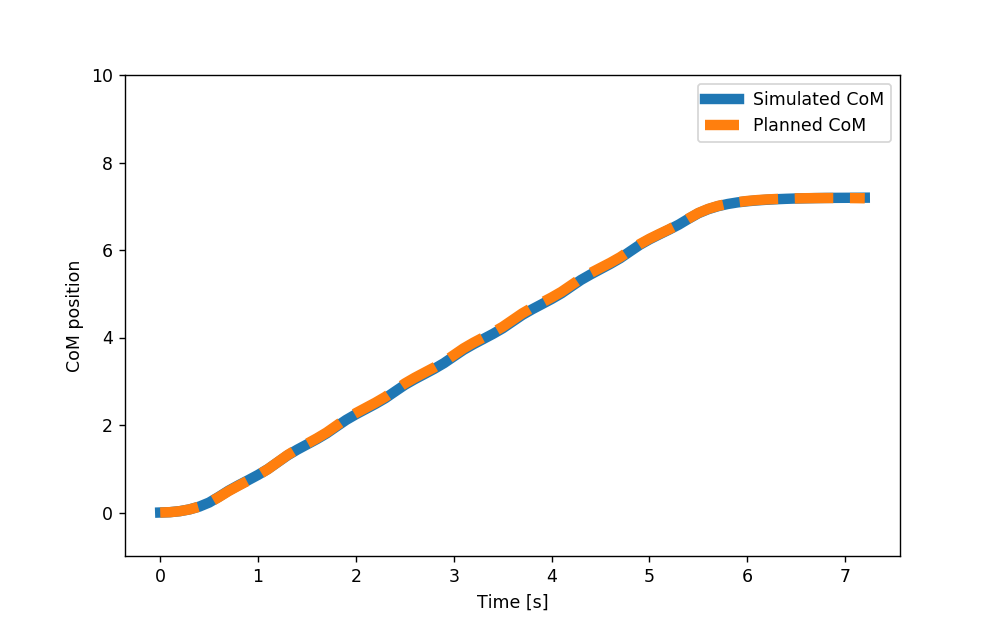

<IPython.core.display.Javascript object>


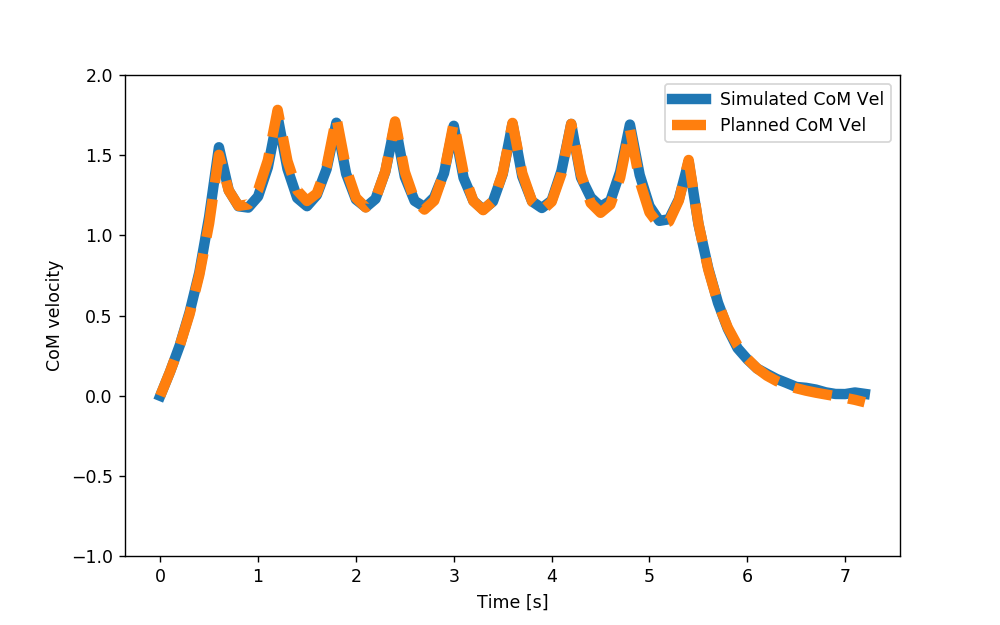

<IPython.core.display.Javascript object>


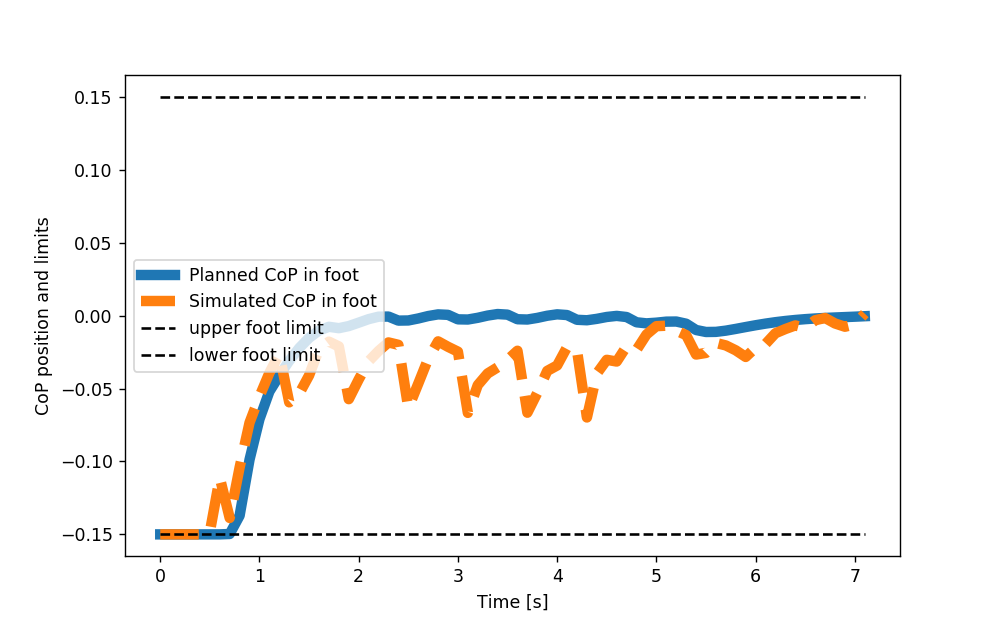

<IPython.core.display.Javascript object>


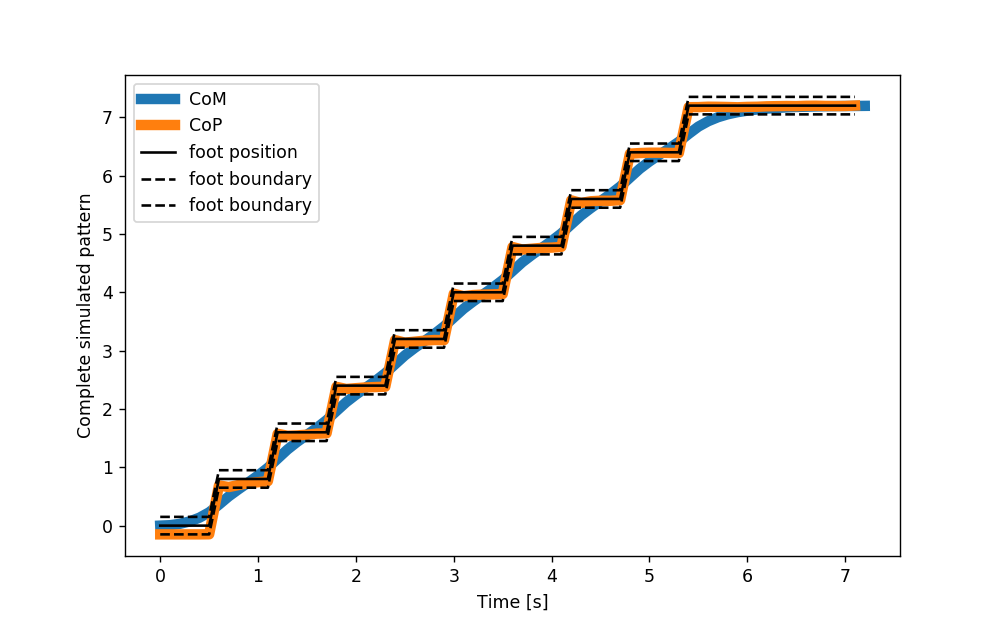

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABaaW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAyBZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjphAZbmOcdwu2wwaf+QclE2IUVk7ICD
zJkRF6bTnhVTeGhZaVM5t1tp76QeYwtZ9a21U6INDaifb7bmglsL3t0dY5ySjbw5f1OUXNEPdaeL
j8cU8xh6xu8sBVBoL8lMF67LzvgcqYSGEl2dE3iD8ie2JlOR34cI87FG4rqSzVaWBMoHv+oOk83C
aLpf1ZvVfbjxNitXMBd7s2PFnLui/jNqtI5VtcT0RypN2YqGAQK/vAlakoVY697k75hXQ6o/jB3i
oGZ4rFjVjzgwG9k84SrvmMB7hmg5s925KiAa4PKpVwy6amaCvFdQ9EzWeNkk0LeaWgFZ1Lj0gy6m
+jPOIpv7V/KYBs8KQlhivDmbhc8oTujsH9bujfwvuO4t+gDCKwtlFf3iiCTVJ0BjodvKyx+7SbAj
3ciuvis4nEr9D/TVRBfgnvZ4sv8F2q8uxhTZVpRFz6po0MsDu7fBkR/K//usx6tv4Zu13W6vQQX/
/U6O20j5hqw/R9FvwOEBUfxf3N4lbidQgBky05Y8Yw/0ap/iAEKRdi5LdFrsYwEKCT2yQbnJnYNW
ad7gahnVXvqAeJ8MmSMh2AukGRzbnzcDqQDadyNqi4R9YjDx+8WD4iAUATzes/h5jhCUulRDuC/W
2oazyYxwsrUWwHxNX1PKO/Ar0MIRxzEExWNMfGVgMmXCk4j9H+waqmBLWKeW70eMNpwmxmTgJUtt
N5k3DWu/UHfwVNlMZeoBYw3KUTo5yY+QnFyYZRlbMFte/9jhOidAXCpa6DCdpyxZX2x08qPW8F0D
cbvwYNTOGhbilCq7mGrHxB5W6ApADpBj35cVXv99q4nQ+9b+I8IsMbaYCJZj5Ms0jLSdy/pyxZaj
uQ+6/aXAdAfxWBZOlaSV8PSxr6JxXwVTmUEuXXDqvB8FdSAp94ai/fq4Hd8nkkdJ97UXkztbfANa
cNQzJ2pVGag8x/OGRrIkGgdeagv6DZ2Aw2xiB02irgBaIJCkB2ljF/8Nhi5yqEvxiWNcdoPZjl0Y
FEtasMTAPXBuP/54H9HeaIl2lSnl4CuP9t5o25n7AzeYZ09Rf4go/9ED8g131bA5hvaaQ9c+Xpmr
vJ72+FG2GJj/NBzTinF092vphjWfg8FYOB7MVEhu8F2n8D12FPw4kDo/QS3V/8PklBP2vZtCStY4
hKsDXdGErAg27HIIiy6XrHx0qT65VNwxTxicBK6WaDJMGo5LAr8FkOGNEAx1CpBSs6IiWHoPJXdj
Oq5cWzKmaHz5RZd1YNO8YaNffQGChmIBBHz+mNJIWEHbVes7oLeLKI/WyrYBwiNEprp1dPPIWWey
hgFXpseQD7DNgnD3bAO8hqJQFFEhYJ4gE215WwaftdjpNa5eY641lYasQytxy5OACw/1KcwtmWt/
VuIuk0FY19Qjmf+gzloTGVj5Az41CRi0hK51tZFcYzyGlsAGR7ODaCGIi+5q0gBuFwBoejvzBbv8
x4MOLJNYdDtVk8b+agorcdcfqo7/k8Xxj5vamEc/9Hx8DafG8SqEaVNI++LkTXTdjGaykpg2bIC8
z46wDikMlojBxBozMiiC+hBqFGGbPb0/BlshNNwPpk39Dov+eabYw6/j1+JLdVUr65L443SHaLMn
tN46dul5BwuyPFDVwY6t7xjsz5LhmYeDgJS8fNajxKFU1QvtUh76X5hdJaGFLWvLf1+J/jcxN1/e
5tbRu7DO337MMspjq22ESKuG+taGYr78RmuGYifPNnSzeY6PpUL7ne2y48gkPiw5WA8e+/sDIOow
nemnpLgc8xJGNsyFgUkwe06De4U38ypkxU11Cr07hSjozbkZDT8aXzpwkBHm3hih8M8mVBgbflLR
mh62F1QcvcJc0XHfMs5W5S8CdEBWg7p4Y4KHvxSOX4X5AegbJT20AE2f+XFDZVpoNL2rDeWgiP/F
sl4a0aiTfzKsQGJwo+J1Ca23A0efaaOpUux1isCRtlj+56PW++7C5bsea+xLYN6+mjoEg3ML7I2Q
/W2VwqzSNU77cHrEC4S6Q74EUimVE8f+nLcfvoyLZYT/b+1Vm6xQgi4hq9C2/0GGkzTINay7hFhG
sJs+MM3faxeP9K6gGA0047vVlq6/fx1rQz7ZQ/TehH2kYGDURJh0EVVs2VnYs1YN/v1PJFFh7j3H
+CaXAWo7OPlostkJMLNqoBsM/10vc/oPONaM3pRA6EemL7FX925D0svk/OinKF3X1KkXG4xGTjnu
HWGg9GPdYdk6+hxO8v5/44xoYYsT/MI4Sm8Z89udyZwdUKvQ+QxLBiFMQIVG+iRXOpcCFwNinYBP
i49aqFVl+r73JGBfknzSg0UJZRCDQpC5yiiRoJgFgsMDVw30H69ol4M+QjtX31iWLNHm9DDghYqe
40F0QerDt3KUzL78cx+tfE5RsEOlUz66NgiFfLtuthrJ/fj3JMkhRhGTJlqSWRFML6XDV0a7iGH9
kKGXFBO07zg0HexJ5dwlQYFXnlhPcwhv6l1G+Sb2HxR9ouPPmnvb31Tltu31gYUUDa4YR3A46jen
tiQS2lokRZU8svGc7lY8WZDz+b8T3wwFGv8/isRgCc2s6yESu/HwhyGtXWqe4zWWqmOgFLTBw3In
NuYdlr9wP00dqBdtbaCwT

In [8]:
# first lets create a walking model
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(step_time / walking_model.dt)

# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2)
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))

# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)


#Defined the model predictive controller
def model_predictive_controller(x,i):
    
    #horizon length used for the controller 
    horizon_small = 12#44

    # now we can construct the optimal control problem as follows
    # we will define bounds of the form G_bounds [x u]^T < h_bounds
    G_bounds_new = []
    h_bounds_new = []
    # the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
    Q_new = []
    q_new = []
    R_new = []
    r_new = []
    
    for j in range(horizon_small):
        if i+j >= len(foot_position):
            current_foot_position = foot_position[len(foot_position)-1]
        else:
            current_foot_position = foot_position[ i + j ]
        
        if j == horizon_small-1:
            Q_nominal_new = np.eye(2)*10**2
        else:
            Q_nominal_new = np.eye(2)

        Q_new.append(Q_nominal_new)
        # we want the CoM above the foot and 0 velocity
        q_new.append(Q_nominal_new.dot(np.array([[-current_foot_position],[0.]])))

        R_nominal_new = 100*np.eye(1)
        R_new.append(R_nominal_new)
        # we want the CoP in the center of the foot
        r_new.append(R_nominal_new.dot(np.array([-current_foot_position])))

        # we create bounds for the CoP location
        G_bounds_new.append(np.array([[0,0,1],[0,0,-1]]))
        h_bounds_new.append(np.array([[walking_model.foot_size + current_foot_position],[walking_model.foot_size-current_foot_position]]))

    # now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
    x_new_plan, u_new_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q_new,q_new,R_new,r_new,G_bounds_new,h_bounds_new, horizon_small, x)

    return u_new_plan[0,0]
    
# we simulate the LIPM using the feedforward controller (no noise)
#x_real,u_real = walking_model.simulate(x0, model_predictive_controller, horizon_length, foot_position, noise=False)
x_real,u_real = walking_model.simulate(x0, model_predictive_controller, horizon_length, foot_position, noise=True)


# we plot the resulting motion vs. the motion that was planned and the associated CoP
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

When the terminal cost is made 10$^9$, the minimum horizon length required to get the system to stabilize increases to about 44, a little over 6 steps. The CoP of the system at 44 receding horizon length, it is erratic in the start before it gets stable at around the fifth step. 
<p>
By observing the overall behaviour of increasing terminal cost, it was understood that increasing the terminal cost causes the CoP of the system to be slightly more erratic after the first step, but stabilizes at the end, unless the terminal cost is too high, in which case the receding horizon length needs to be high enough to not disturb the trajectory too much.

<b>When the receding horizon length increases</b> the system is observed to become more and more stable, with the CoP of the simulation closer to the center of the foot, i.e. the planned CoP.